<a href="https://colab.research.google.com/github/arvieira/bootcamp_modulo_03/blob/main/Notebook/ProjetoModulo03BootcampAlura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img src="https://raw.githubusercontent.com/arvieira/bootcamp_modulo_03/main/Images/nostradamos.jpg" width = 70%>
</p>

# Projeto: Prevendo Novos Óbitos por COVID19 com o Facebook Prophet
#####Aluno: André Vieira
---
- # Dos Dados:

Os dados analisados nesse estudo são provenientes do site https://brasil.io.
Trata-se de um portal contendo um repositório de dados públicos disponibilizados de maneira adequada para a realização de estudos estatísticos.

Com a pandemia SARS-CoV-2, o site disponibilizou uma equipe para a coleta, aquisição e compilação dos dados referentes a novos casos e óbitos para os municípios do território brasileiro. 
Cabe ressaltar, que os dados presentes no referido site não são divulgados pelo ministério da saúde, o que pode apresentar divergências nas informações apresentadas por aquele.

A tabela utilizada possui os casos confirmados e óbitos obtidos dos boletins das Secretarias Estaduais de Saúde (SES). 
Os dados foram enriquecidos, de forma que a partir do momento em que um município confirma um caso, ele sempre aparecerá nessa tabela (mesmo que para uma determinada data a SES não tenha liberado o boletim - nesse caso é repetido o dado do dia anterior). 
Mais especificamente para este estudo, foram utilizados os dados de óbitos fornecidos por cartórios. 

---
- # Do Objetivo

O objetivo dessa análise é a realização de uma análise exploratória dos dados históricos dos números acumulados e de novos casos de óbitos por covid19 para o estado do Rio de janeiro.
Para tanto, foram obtidas séries históricas dos dados que compõem as os itens pesquisados separados por unidades da federação.
Após a análise exploratória e limpeza dos dados, este estudo terá como foco a criação de configuração de um modelo para realizar a previsão de novos casos para um prazo de 30 dias (1 mês).
Assim como, analisar a qualidade das previsões realizadas pelo modelo construído levando em consideração métricas de erros.

---
- # Da Pergunta
  - Há uma forma de se criar um modelo para realizar as previsões?
  - Qual o erro médio absoluto para cada dia de previsão dentro dos 30 dias seguintes aos dados?

# Configurações e Importação de Bibliotecas e Dados

In [474]:
# Desabilitando possíveis avisos 
import warnings
warnings.filterwarnings('ignore')

In [475]:
# Importações das bibliotecas utilizadas
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from pandas.plotting import autocorrelation_plot
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [476]:
# Definindo parâmetros das figuras do notebook
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (15, 8)

In [477]:
# Endereço da base de dados.
# Foi utilizada a base de óbitos dos cartórios com a causa da morte de 2019 e 2020
# https://brasil.io/dataset/covid19/caso_full/
dados = pd.read_csv('https://github.com/arvieira/bootcamp_modulo_03/blob/main/Dados/obito_cartorio.csv.gz?raw=true',
                    compression='gzip')

# Analise Exploratória dos Dados

In [478]:
# Explorando a tabela para visualizar as informações que ela traz
dados.head()

,date,state,epidemiological_week_2019,epidemiological_week_2020,deaths_indeterminate_2019,deaths_respiratory_failure_2019,deaths_others_2019,deaths_pneumonia_2019,deaths_septicemia_2019,deaths_sars_2019,deaths_covid19,deaths_indeterminate_2020,deaths_respiratory_failure_2020,deaths_others_2020,deaths_pneumonia_2020,deaths_septicemia_2020,deaths_sars_2020,deaths_total_2019,deaths_total_2020,new_deaths_indeterminate_2019,new_deaths_respiratory_failure_2019,new_deaths_others_2019,new_deaths_pneumonia_2019,new_deaths_septicemia_2019,new_deaths_sars_2019,new_deaths_covid19,new_deaths_indeterminate_2020,new_deaths_respiratory_failure_2020,new_deaths_others_2020,new_deaths_pneumonia_2020,new_deaths_septicemia_2020,new_deaths_sars_2020,new_deaths_total_2019,new_deaths_total_2020
0,2020-01-01,AC,1,1,0,2,4,3,1,0,0,1,1,8,2,2,0,10,14,NaN,2.0,4.0,3.0,1.0,NaN,NaN,1.0,1.0,8.0,2.0,2.0,NaN,10,14
1,2020-01-02,AC,1,1,0,2,10,3,2,0,0,1,1,14,4,4,0,17,24,NaN,NaN,6.0,NaN,1.0,NaN,NaN,NaN,NaN,6.0,2.0,2.0,NaN,7,10
2,2020-01-03,AC,1,1,0,2,16,3,4,0,0,1,1,22,7,6,0,25,37,NaN,NaN,6.0,NaN,2.0,NaN,NaN,NaN,NaN,8.0,3.0,2.0,NaN,8,13
3,2020-01-04,AC,1,1,0,2,18,6,5,0,0,1,2,26,7,7,0,31,43,NaN,NaN,2.0,3.0,1.0,NaN,NaN,NaN,1.0,4.0,NaN,1.0,NaN,6,6
4,2020-01-05,AC,1,2,0,2,24,7,5,0,0,1,3,30,11,7,0,38,52,NaN,NaN,6.0,1.0,NaN,NaN,NaN,NaN,1.0,4.0,4.0,NaN,NaN,7,9


In [479]:
# Criando uma coluna nova chamada datetime que irá conter a data como um datetime
dados['datetime'] = pd.to_datetime(dados['date'], format='%Y-%m-%d')

---
A visualização a seguir mostra uma linha de tendência dos dados em azul escuro e uma nuvem de pontos que se assemelha um intervalo de confiança, apesar de não ser. 
Essa nuvem é causada porque os dados apresentam os óbitos nos diferentes estados da federação. 
Então, para cada data, eu tenho um valor para cada estado.

---

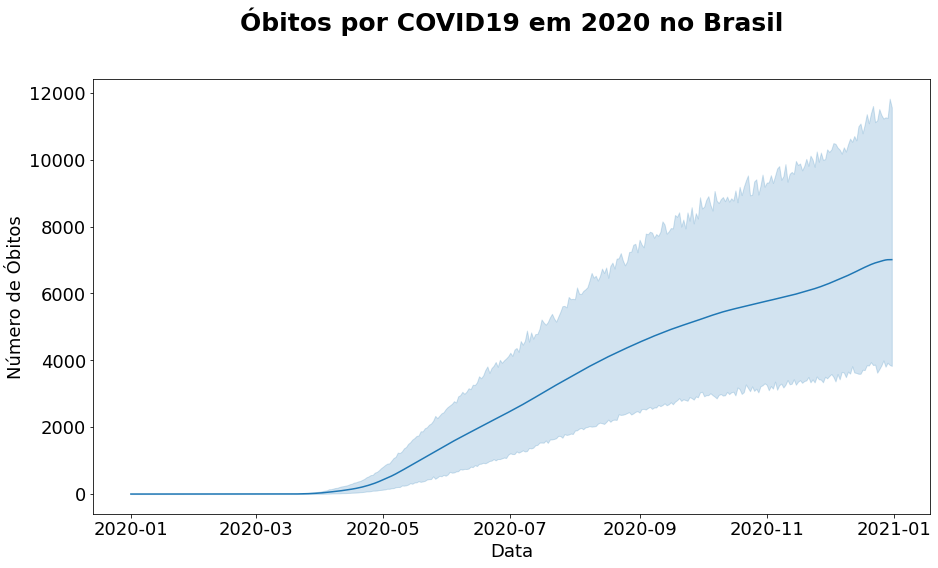

In [480]:
# Criação da visualização
ax = sns.lineplot(x='datetime', y='deaths_covid19', data=dados)
ax.set(xlabel='Data', ylabel='Número de Óbitos')
ax.text(x=0.5, y=1.1, s='Óbitos por COVID19 em 2020 no Brasil', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
plt.show()

In [481]:
# Filtrando para apresentar os casos de óbitos apenas do Rio de Janeiro em um 
# novo dataframe formatado
dados_rj = pd.DataFrame()
dados_rj['Data'] = dados.query('state == "RJ"')['datetime']
dados_rj['Óbitos Acumulados'] = dados.query('state == "RJ"')['deaths_covid19']
dados_rj['Novos Óbitos'] = dados.query('state == "RJ"')['new_deaths_covid19']
dados_rj.head()

,Data,Óbitos Acumulados,Novos Óbitos
6588,2020-01-01,0,NaN
6589,2020-01-02,0,NaN
6590,2020-01-03,0,NaN
6591,2020-01-04,0,NaN
6592,2020-01-05,0,NaN


In [482]:
# Verificando todos os valores que são núlos no dataframe para óbitos acumulados
dados_rj['Óbitos Acumulados'].isnull().sum()

0

In [483]:
# Verificando todos os valores que são núlos no dataframe para novos óbitos
dados_rj['Novos Óbitos'].isnull().sum()

77

In [484]:
# Verificando o tipo dos dados para o dataframe. Não há objetos que poderiam
# gerar problemas nas análises. Apenas os NaN em pontos que não possuem dados.
# Iremos substituir os NaN por zero acreditando que esses dados ficaram represados
# e foram reportados em datas futuras.
dados_rj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 6588 to 6953
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Data               366 non-null    datetime64[ns]
 1   Óbitos Acumulados  366 non-null    int64         
 2   Novos Óbitos       289 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.4 KB


In [485]:
# Realizando a substituição dos NaN por zero.
dados_rj['Novos Óbitos'] = dados_rj['Novos Óbitos'].fillna(0)
dados_rj['Novos Óbitos'].isnull().sum()

0

---
Durante a análise do conjunto de dados, foram identificadas 77 ocorrências de falta de dados.
Foi considerado que a falta de dados representa o represamento de dados que serão apresentados nos dias seguintes. 
Logo, optou-se por preencher as referidas lacunas com o valor zero.

A visualização a seguir apresenta a evolução do número de mortes por covid19 no ano de 2020 para o estado do Rio de Janeiro. 
Serão utilizadas as datas por dias em vez de semanas epidemiológicas para possibilitar a análise da sazonalidade semanal e mensal dos dados.

---

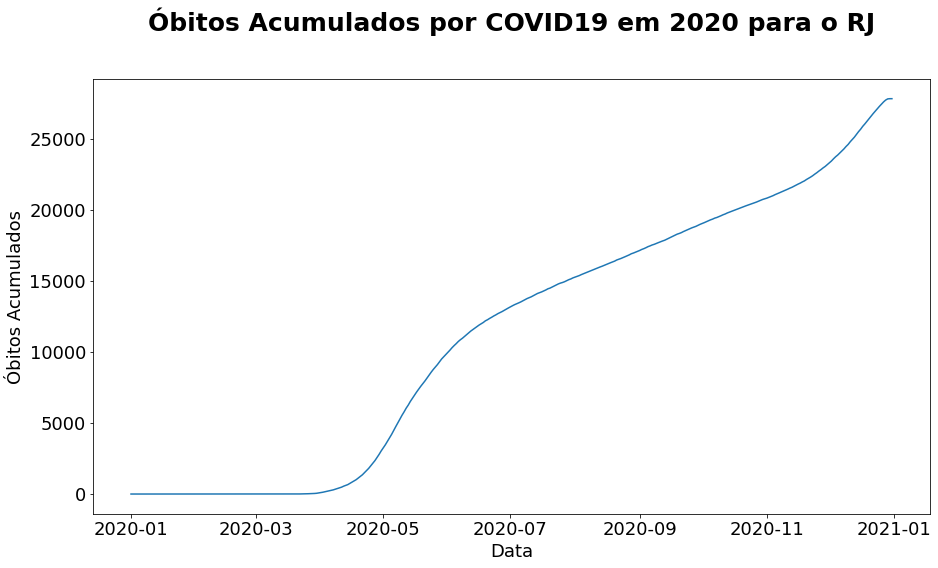

In [486]:
# Construção do gráfico para o estado do Rio de Janeiro
ax = sns.lineplot(x='Data', y='Óbitos Acumulados', data=dados_rj)
ax.text(x=0.5, y=1.1, s='Óbitos Acumulados por COVID19 em 2020 para o RJ', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
plt.show()

---
A visualização anterior apresenta o número de óbitos acumulados para o estado do Rio de Janeiro.
Suspeita-se de que a referida curva se trata de uma exponencial e para esta análise será utilizada uma visualização com escala logarítmica.
A visualização em escala logarítmica utiliza o logarítmo do número de óbitos ao invés do próprio valor. 
Isso transforma uma curva exponencial em uma reta.
A inclinação da reta mostra o quão alta é a taxa de crescimento da curva exponencial. 

No caso da próxima visualização, pode-se observar uma reta quase vertical no período de março a maio de 2020, o que implica em uma curva exponencial de óbitos com grande taxa de crescimento. 
De maio a junho há uma transição da taxa, estabilizando aproximadamente em uma reta quase horizontal nos meses seguintes. 
A reta quase horizontal não indica uma estabilidade, mas sim um crescimento exponencial mais devagar, mesmo ainda sendo exponencial.

---

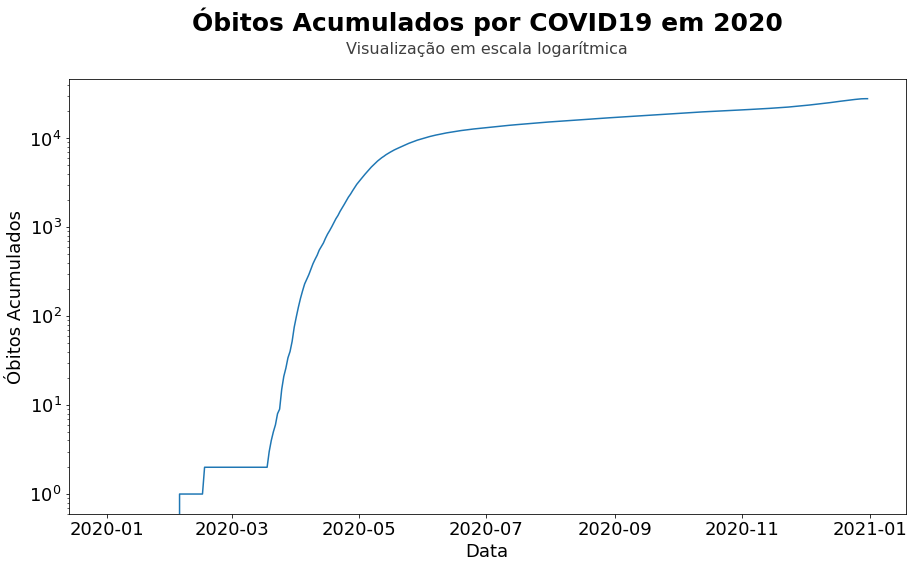

In [487]:
# Construção da visualização em escala logarítmica
ax = sns.lineplot(x='Data', y='Óbitos Acumulados', data=dados_rj)
ax.text(x=0.5, y=1.1, s='Óbitos Acumulados por COVID19 em 2020', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Visualização em escala logarítmica', fontsize=16, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
mpl.pyplot.yscale('log')
plt.show()

---
Exibindo as derivadas da curva de modo a apresentar as taxas de crescimento da curva exponencial associada.
<p align="center">
  <img src="https://raw.githubusercontent.com/arvieira/bootcamp_modulo_03/main/Images/Derivadas.png" width = 100%>
</p>

---

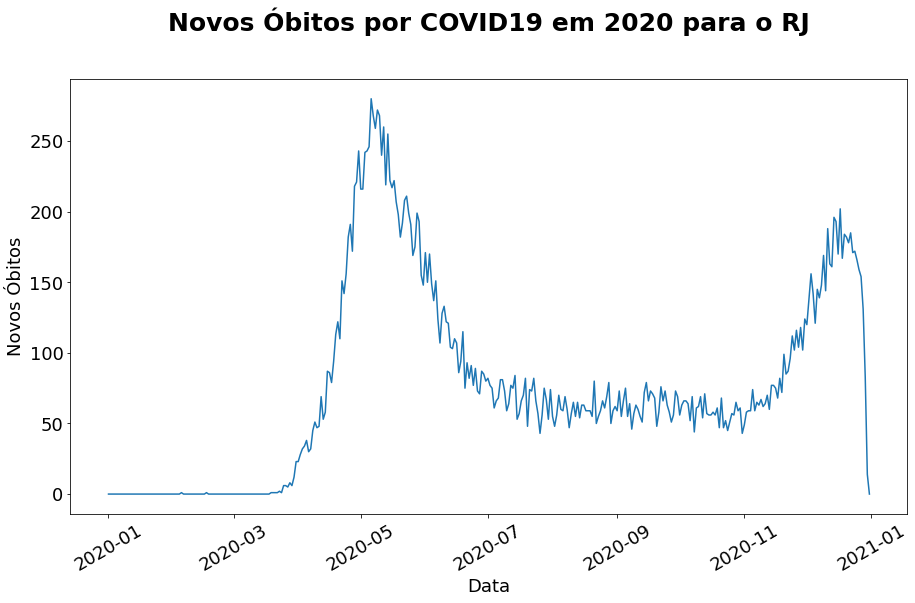

In [488]:
# Construção da curva de novos óbitos
ax = sns.lineplot(x='Data', y='Novos Óbitos', data=dados_rj)
ax.text(x=0.5, y=1.1, s='Novos Óbitos por COVID19 em 2020 para o RJ', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
plt.xticks(rotation=30)
plt.show()

---
Há a percepção de que os óbitos da última semana do ano de 2020 ficaram represados, de modo a só serem reportados no ano seguinte. 
Logo, o dado do referido dia será descartado.

---

In [489]:
# Retirada dos dados da última semana
dados_rj = dados_rj.drop(dados_rj[dados_rj['Data'] >= '2020-12-27'].index)
dados_rj.tail()

,Data,Óbitos Acumulados,Novos Óbitos
6944,2020-12-22,26761,185.0
6945,2020-12-23,26932,171.0
6946,2020-12-24,27104,172.0
6947,2020-12-25,27270,166.0
6948,2020-12-26,27429,159.0


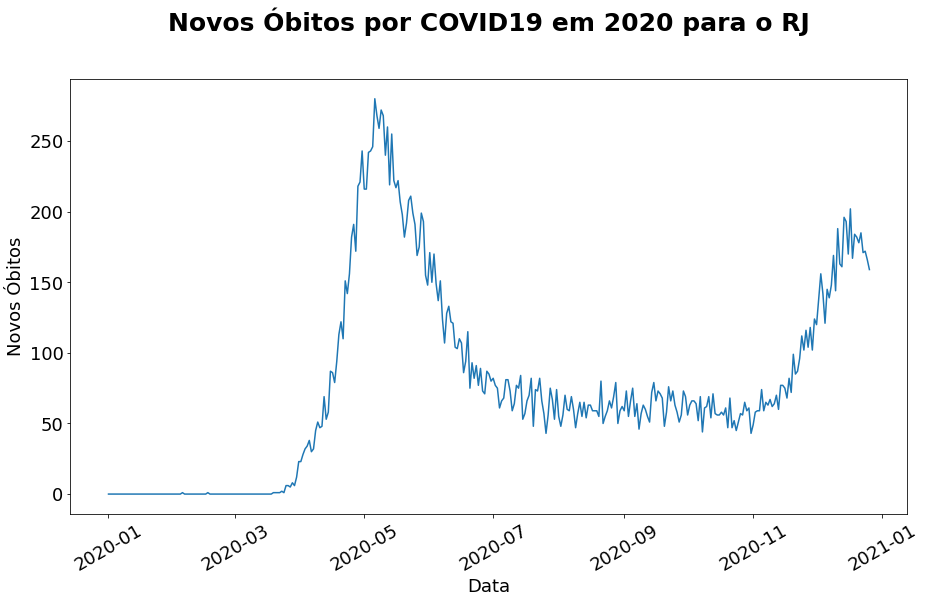

In [490]:
# Construção da nova visualização
ax = sns.lineplot(x='Data', y='Novos Óbitos', data=dados_rj)
ax.text(x=0.5, y=1.1, s='Novos Óbitos por COVID19 em 2020 para o RJ', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
plt.xticks(rotation=30)
plt.show()

---
Como pode ser visto na visualização anterior, o número de óbitos cresce e decresce várias vezes seguidas formando uma linha em formato de dente de serra.
Cada pequena subida gera uma taxa de crescimento positiva e cada descida gera uma taxa negativa. 
A seguir se encontra a visualização da referida taxa no tempo. 

Como pode ser visto, a linha oscila em torno do valor zero com taxas positivas
e negativas. 
Conforme se tem mais taxas positivas maiores, o número de óbitos
está em crescimento. 
Caso constrário, está em queda.

---

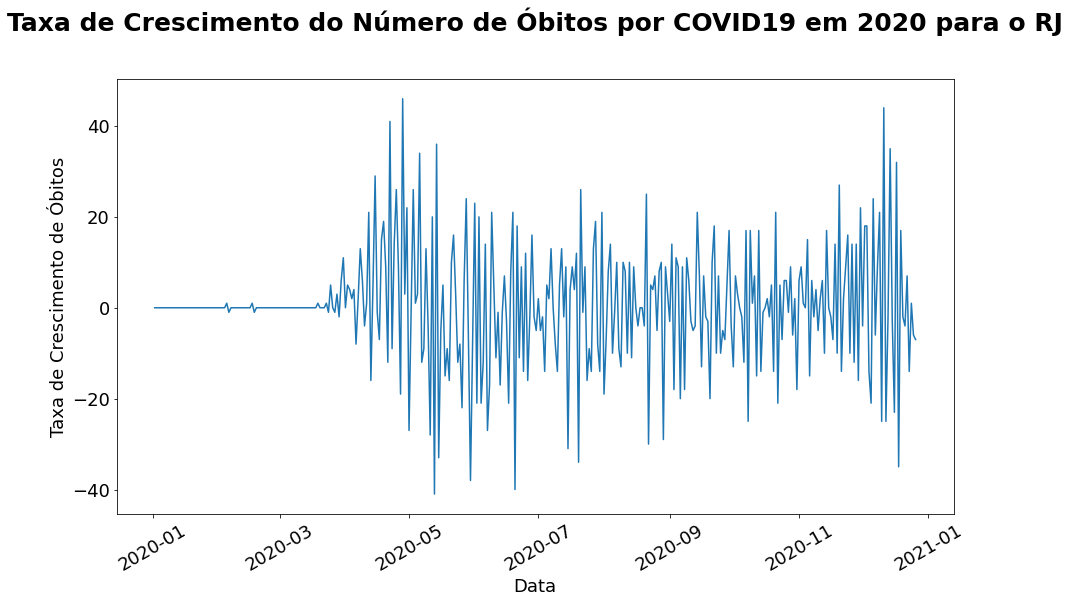

In [491]:
# Construção da visualização da taxa de crescimento
dados_rj['Taxa de Crescimento de Óbitos'] = dados_rj['Novos Óbitos'].diff()
ax = sns.lineplot(x='Data', y='Taxa de Crescimento de Óbitos', data=dados_rj)
ax.text(x=0.5, y=1.1, s='Taxa de Crescimento do Número de Óbitos por COVID19 em 2020 para o RJ', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
plt.xticks(rotation=30)
plt.show()

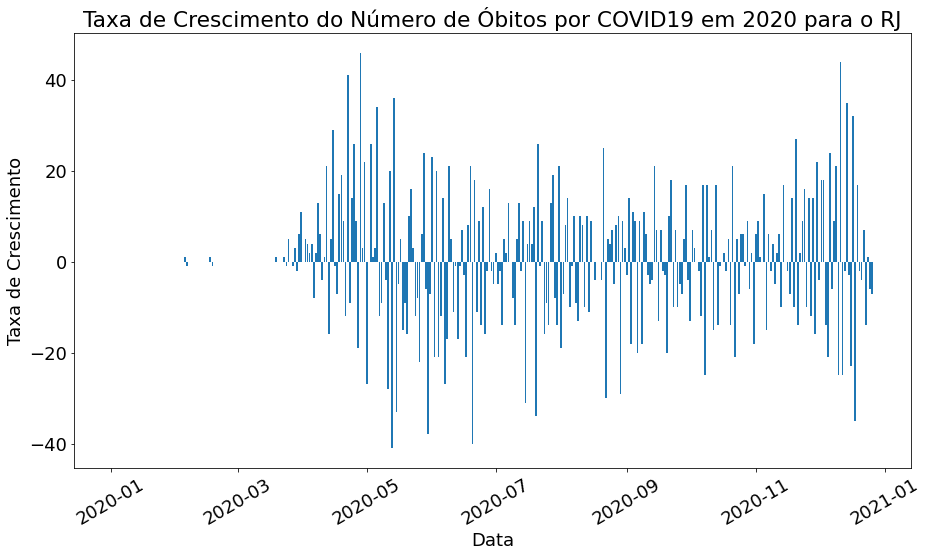

In [492]:
# A mesma visualização anterior, porém em barras
plt.bar(dados_rj['Data'], dados_rj['Taxa de Crescimento de Óbitos'])
plt.title('Taxa de Crescimento do Número de Óbitos por COVID19 em 2020 para o RJ')
plt.xticks(rotation=30)
plt.xlabel('Data')
plt.ylabel('Taxa de Crescimento')
plt.show()

---
Após o cálculo da taxa de crescimento em cada ponto, agora será construída a média móvel para cada ponto. 
A exibição da mesma será no final do intervalo de 7 dias anterior. 
Foi escolhido esse intervalo para a representar uma semana.

Assim como a taxa de crescimento tem o valor NaN para o primeiro por não possuir
elemento anterior para fazer a diferença, a média móvel não terá os 6 primeiros
elementos porque a janela é de 7 dias (1 semana).

---

In [493]:
# Cálculo da média móvel com janela de uma semana
dados_rj['Média Móvel de Óbitos'] = dados_rj['Novos Óbitos'].rolling(window=7, center=False).mean()
dados_rj.head(14)

,Data,Óbitos Acumulados,Novos Óbitos,Taxa de Crescimento de Óbitos,Média Móvel de Óbitos
6588,2020-01-01,0,0.0,NaN,NaN
6589,2020-01-02,0,0.0,0.0,NaN
6590,2020-01-03,0,0.0,0.0,NaN
6591,2020-01-04,0,0.0,0.0,NaN
6592,2020-01-05,0,0.0,0.0,NaN
6593,2020-01-06,0,0.0,0.0,NaN
6594,2020-01-07,0,0.0,0.0,0.0
6595,2020-01-08,0,0.0,0.0,0.0
6596,2020-01-09,0,0.0,0.0,0.0
6597,2020-01-10,0,0.0,0.0,0.0


In [494]:
# Realizando o melt dos dados para poder exibir em um único gráfico com legenda
# para as curvas de novos óbitos e média móvel.
dados_temp = pd.DataFrame()
dados_temp = dados_rj.drop(['Óbitos Acumulados', 'Taxa de Crescimento de Óbitos'], axis=1)
dados_temp = dados_temp.set_index('Data')
dados_temp = dados_temp.reset_index().melt(id_vars=['Data'], value_vars=dados_temp.columns)
dados_temp = dados_temp.rename(columns={'variable': 'Tipo de Métrica', 'value': 'Número de Óbitos'})
dados_temp.head()

,Data,Tipo de Métrica,Número de Óbitos
0,2020-01-01,Novos Óbitos,0.0
1,2020-01-02,Novos Óbitos,0.0
2,2020-01-03,Novos Óbitos,0.0
3,2020-01-04,Novos Óbitos,0.0
4,2020-01-05,Novos Óbitos,0.0


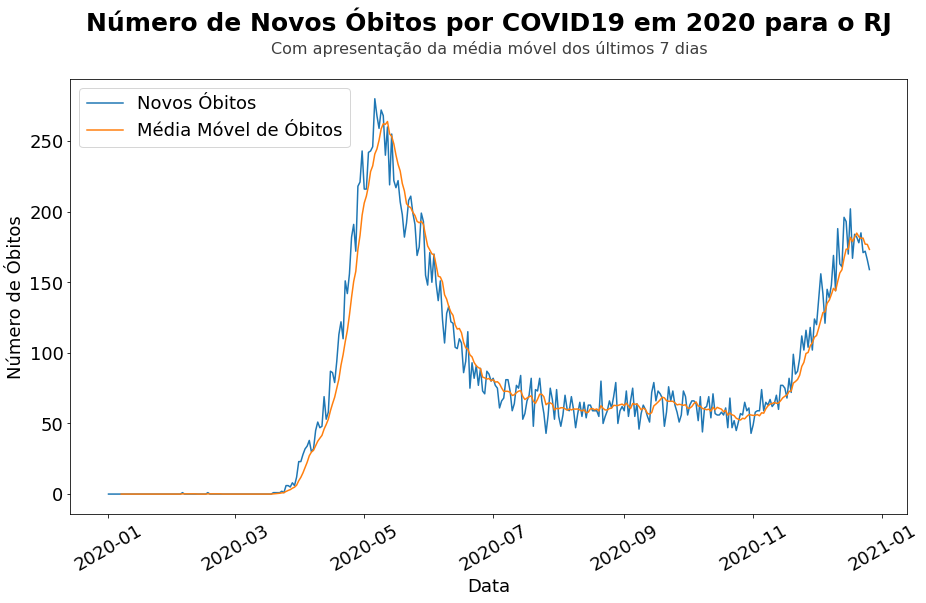

In [495]:
# Exibindo a visualização de novos óbitos com média móvel dos últimos 7 dias
ax = sns.lineplot(x='Data', y='Número de Óbitos', data=dados_temp, hue='Tipo de Métrica', legend=True)
ax.text(x=0.5, y=1.1, s='Número de Novos Óbitos por COVID19 em 2020 para o RJ', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Com apresentação da média móvel dos últimos 7 dias', fontsize=16, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
ax.legend (loc="upper left");
plt.xticks(rotation=30)
plt.show()

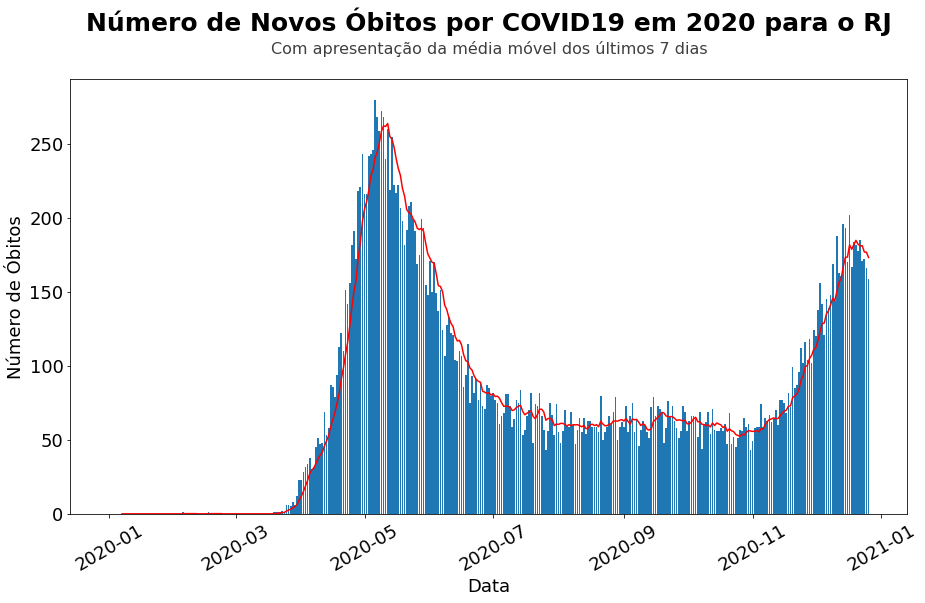

In [496]:
# Visualização de barras e linhas semelhante às apresentadas nos principais 
# meios de comunicação.
plt.bar(dados_rj['Data'], dados_rj['Novos Óbitos'])
ax = sns.lineplot(x='Data', y='Média Móvel de Óbitos', data=dados_rj, color='red')
ax.text(x=0.5, y=1.1, s='Número de Novos Óbitos por COVID19 em 2020 para o RJ', fontsize=25, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Com apresentação da média móvel dos últimos 7 dias', fontsize=16, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
ax.set(ylabel='Número de Óbitos')
plt.xticks(rotation=30)
plt.show()

---
Análise da sazonalidade dos dados:

Nos 3 primeiros meses do ano, os dados apresentam números próximos de zero, 
porque se trata do início da pandemia. 
Serão utilizados meses seguintes. 
No caso, serão usados os meses de abril, maio e junho que representam 
a subida da curva.
Em seguida, serão analisados os meses de agosto, setembro e outubro, que representam um platô da curva.

---

In [497]:
# Seleção dos dados
dados_2020_04 = dados_rj.query('Data >= "2020-04-01" and Data <= "2020-04-30"')
dados_2020_05 = dados_rj.query('Data >= "2020-05-01" and Data <= "2020-05-31"')
dados_2020_06 = dados_rj.query('Data >= "2020-06-01" and Data <= "2020-06-30"')

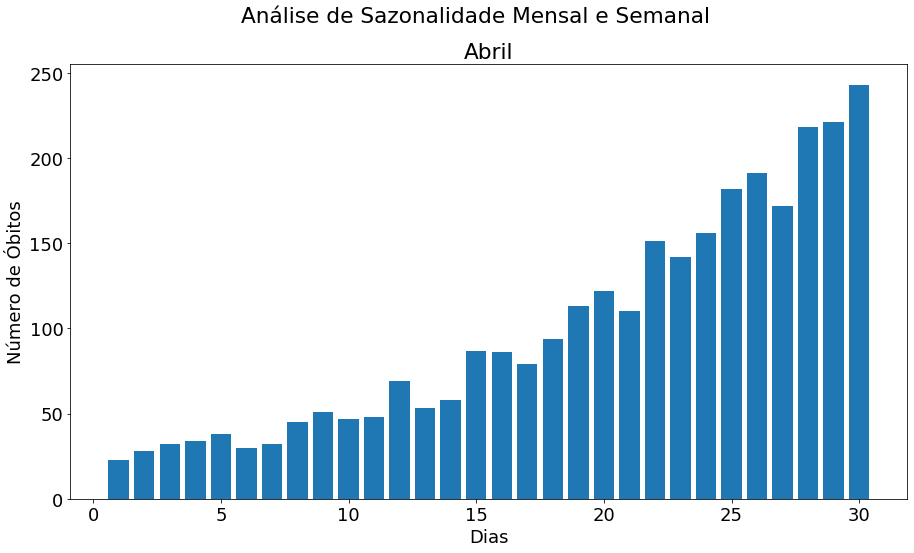

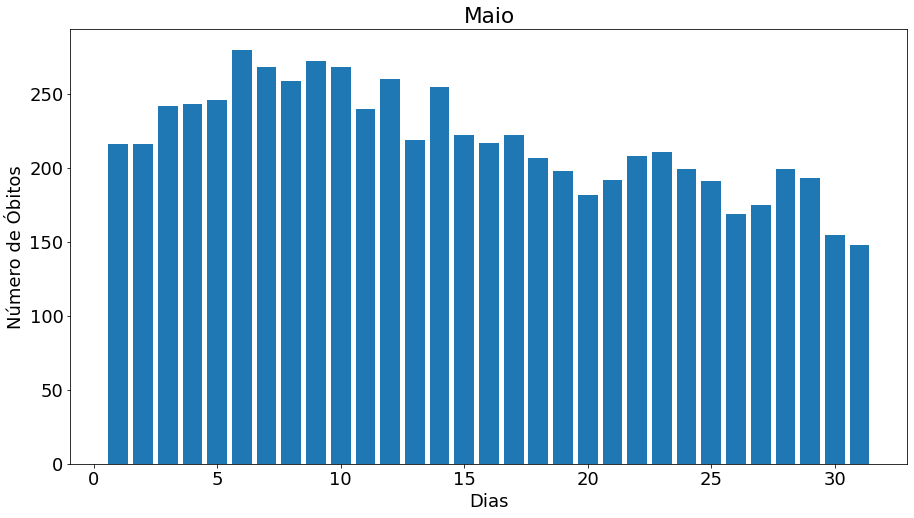

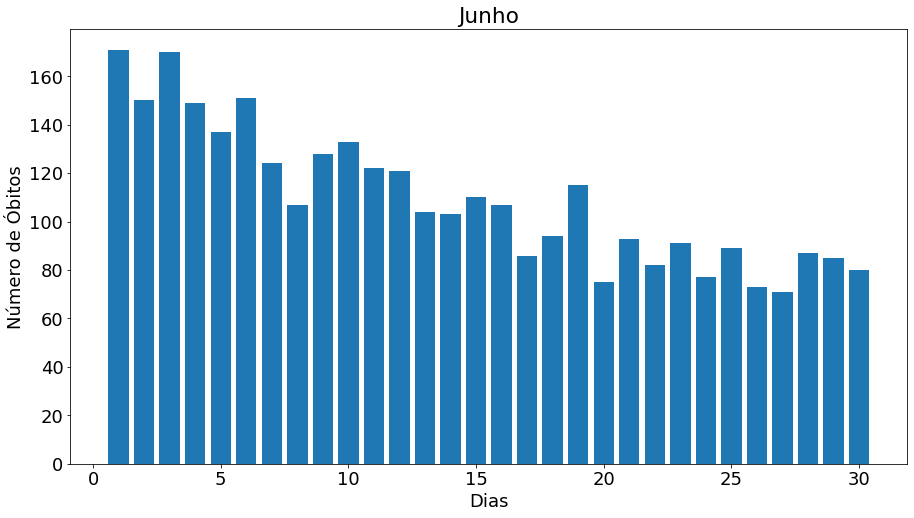

In [498]:
# Comparando os meses de abril, maio e junho de 2020
plt.suptitle('Análise de Sazonalidade Mensal e Semanal')
plt.title('Abril')
plt.bar(np.linspace(1, 30, 30), dados_2020_04['Novos Óbitos'])
plt.xlabel("Dias")
plt.ylabel("Número de Óbitos")
plt.show()

plt.title('Maio')
plt.bar(np.linspace(1, 31, 31), dados_2020_05['Novos Óbitos'])
plt.xlabel("Dias")
plt.ylabel("Número de Óbitos")
plt.show()

plt.title('Junho')
plt.bar(np.linspace(1, 30, 30), dados_2020_06['Novos Óbitos'])
plt.xlabel("Dias")
plt.ylabel("Número de Óbitos")
plt.show()

In [499]:
# Análise da sazonalidade dos dados.
# Avaliando o 3 meses de estabilidade 8, 9 e 10

dados_2020_08 = dados_rj.query('Data >= "2020-08-01" and Data <= "2020-08-31"')
dados_2020_09 = dados_rj.query('Data >= "2020-09-01" and Data <= "2020-09-30"')
dados_2020_10 = dados_rj.query('Data >= "2020-10-01" and Data <= "2020-10-31"')

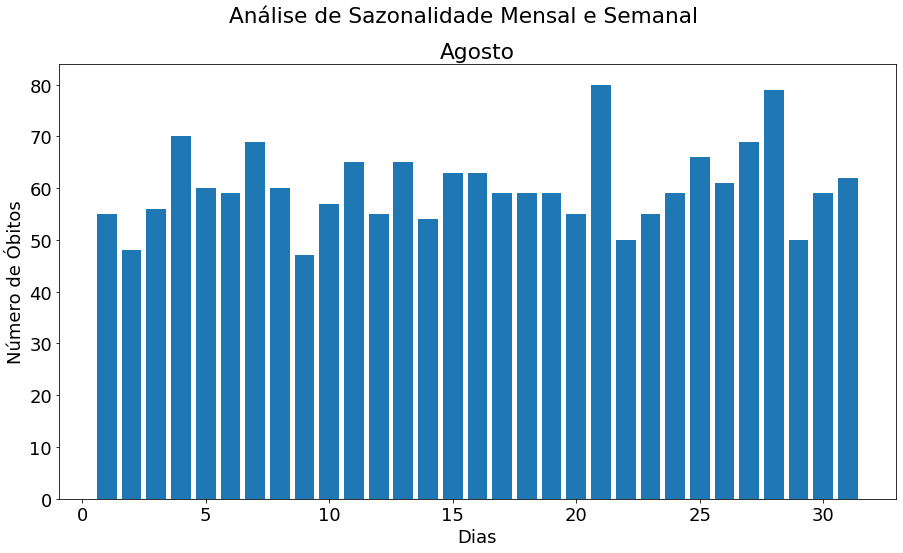

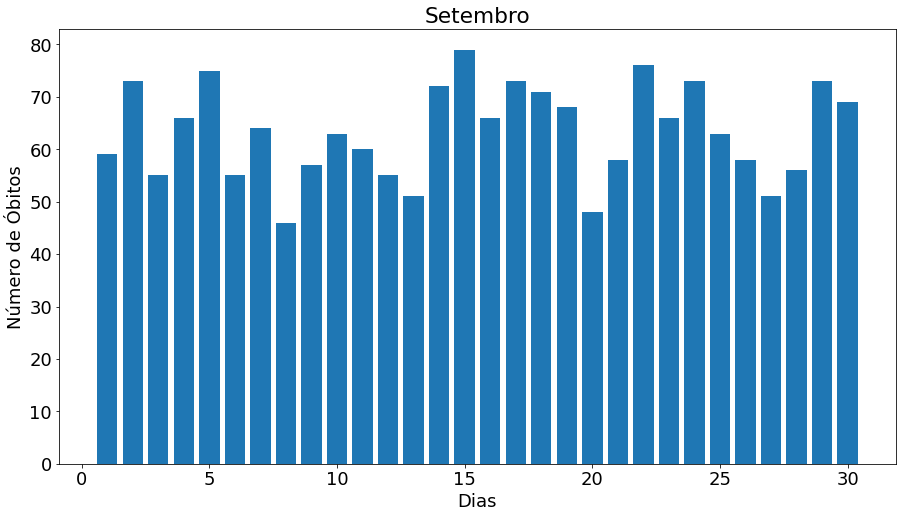

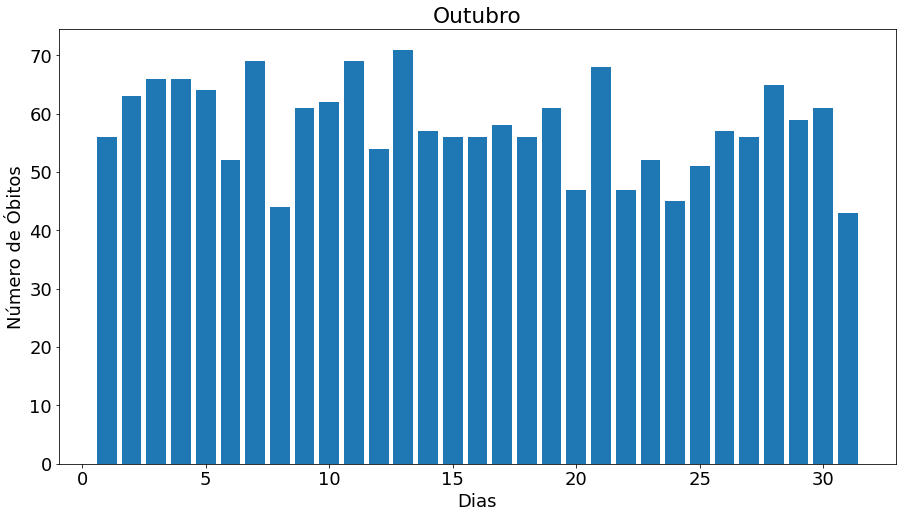

In [500]:
# Nessa visualização começa a aparecer algo como uma sazonalidade semanal nos dados
plt.suptitle('Análise de Sazonalidade Mensal e Semanal')
plt.title('Agosto')
plt.bar(np.linspace(1, 31, 31), dados_2020_08['Novos Óbitos'])
plt.xlabel("Dias")
plt.ylabel("Número de Óbitos")
plt.show()

plt.title('Setembro')
plt.bar(np.linspace(1, 30, 30), dados_2020_09['Novos Óbitos'])
plt.xlabel("Dias")
plt.ylabel("Número de Óbitos")
plt.show()

plt.title('Outubro')
plt.bar(np.linspace(1, 31, 31), dados_2020_10['Novos Óbitos'])
plt.xlabel("Dias")
plt.ylabel("Número de Óbitos")
plt.show()

---
Foi identificada uma pequena sazonalidade semanal com queda de casos no final de semana.
Para se ter um resultado mais acertado acerca do tema, será utilizada uma função de auto correlação da biblioteca pandas para tentar identificar
a sazonalidade dos dados.

Será feita uma comparação dos dados de novos óbitos com ele mesmo deslocado.
Isso é feito fazendo uma cópia dos dados e deslocando a cópia aos poucos, aplicando a correlação com a própria base. 
Esse deslocamento é o LAG representado no eixo x do gráfico.

Quando o lag é zero, os dados estão correlacionados igualmente, ou seja, ele
com ele mesmo, assumindo o valor de 1. 
Esse caso nos daria o maior valor possível para a auto correlação.
Conforme eu tenho sazonalidade nos dados, de lags em lags eu terei uma correlação alta positiva ou negativamente, pq os dados se repetem de tempos em tempos.

O desenho da visualização a seguir apresenta que os dados próximos, ou seja, do início da pandemia com os meses que se seguiram possuem uma maior correlação do que os dados do início da pandemia com o final do período.

Há uma presença de sazonalidade entre meses do ano, mas não semanal. A linha 
da visualização oscila em torno do zero conforme desloco o lag. 
No entanto, essa oscilação é contínua e não em formato de dente de serra, o que mostra que a sazonalidade semanal pode não ser proeminente.

---

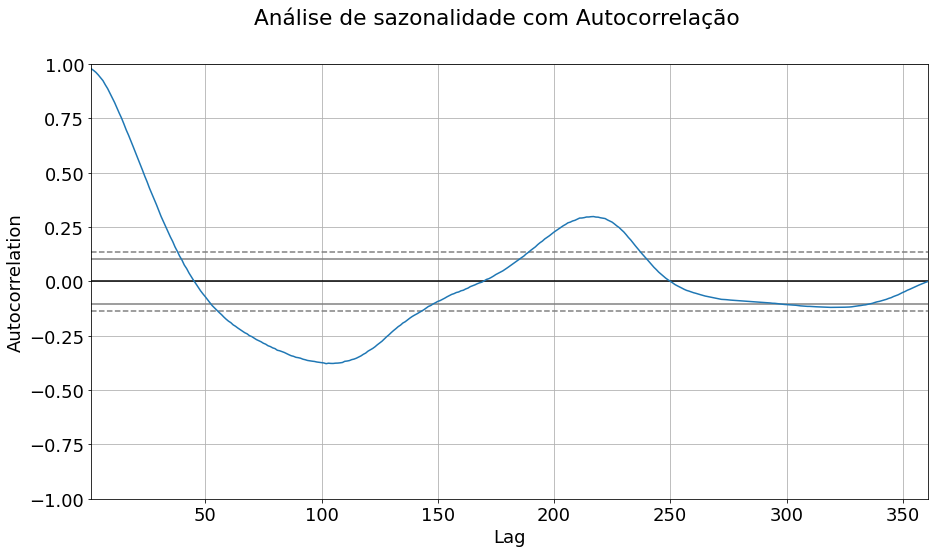

In [501]:
# Construindo visualização da auto correlação
plt.suptitle('Análise de sazonalidade com Autocorrelação')
autocorrelation_plot(dados_rj['Novos Óbitos'])

# Criando um Modelo Ingênuo para Previsão de 30 Dias de Novos Óbitos

---
Iremos utilizar a biblioteca Facebook Prophet para poder criar um modelo de 
previsão de resultados baseados em séries temporais. 
Para tanto, ele detecta sazonalidades semanais, mensais e anuais, levando ainda em consideração dias úteis e feriados próprios dos diferentes países.

Como estamos analisando uma série temporal de novos óbitos por Covid19 no 
estado do Rio de Janeiro, iremos tentar criar um modelo adequado para a 
previsão de dias futuros com o calendário de feriados do estado citado.

(fonte: https://facebook.github.io/prophet/)

---

In [502]:
#O DataFrame utilizado para a criação do modelo precisa de uma coluna temporal
#uma coluna de dados que eu irei prever.
dados_modelo = pd.DataFrame()
dados_modelo['ds'] = dados_rj['Data']
dados_modelo['y'] = dados_rj['Novos Óbitos']

modelo = Prophet()
modelo.fit(dados_modelo)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [503]:
# Criando um DataFrame com as datas equivalentes ao período que eu quero prever.
# No caso, tentaremos prever como se desenhará os novos óbitos para o mês seguinte.
# Utilizando próximos 30 dias.
periodo = 30
periodo_de_previsao = modelo.make_future_dataframe(periods=periodo)

# Realizando a previsão para o próximo mês
previsao = modelo.predict(periodo_de_previsao)
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,-42.618244,-94.419416,14.971561,-42.618244,-42.618244,1.903951,1.903951,1.903951,1.903951,1.903951,1.903951,0.0,0.0,0.0,-40.714292
1,2020-01-02,-41.297631,-89.912287,18.834940,-41.297631,-41.297631,2.349802,2.349802,2.349802,2.349802,2.349802,2.349802,0.0,0.0,0.0,-38.947829
2,2020-01-03,-39.977019,-90.768795,19.168902,-39.977019,-39.977019,1.313510,1.313510,1.313510,1.313510,1.313510,1.313510,0.0,0.0,0.0,-38.663509
3,2020-01-04,-38.656407,-96.501306,10.202255,-38.656407,-38.656407,-2.175058,-2.175058,-2.175058,-2.175058,-2.175058,-2.175058,0.0,0.0,0.0,-40.831465
4,2020-01-05,-37.335795,-95.945101,12.207988,-37.335795,-37.335795,-2.038231,-2.038231,-2.038231,-2.038231,-2.038231,-2.038231,0.0,0.0,0.0,-39.374026


---
Esse primeiro modelo apresenta uma adequação muito ingênua aos dados, de modo 
que teremos de melhorar as características, considerando feriados, finais de 
semana, adicionando mais pontos de inflexão entre outras formas de melhor adequar o modelo aos dados. Ainda assim, para um curto intervalo de tempo, podemos ver que possivelmente os pontos cairão dentro do intervalo de confiança do modelo.

---

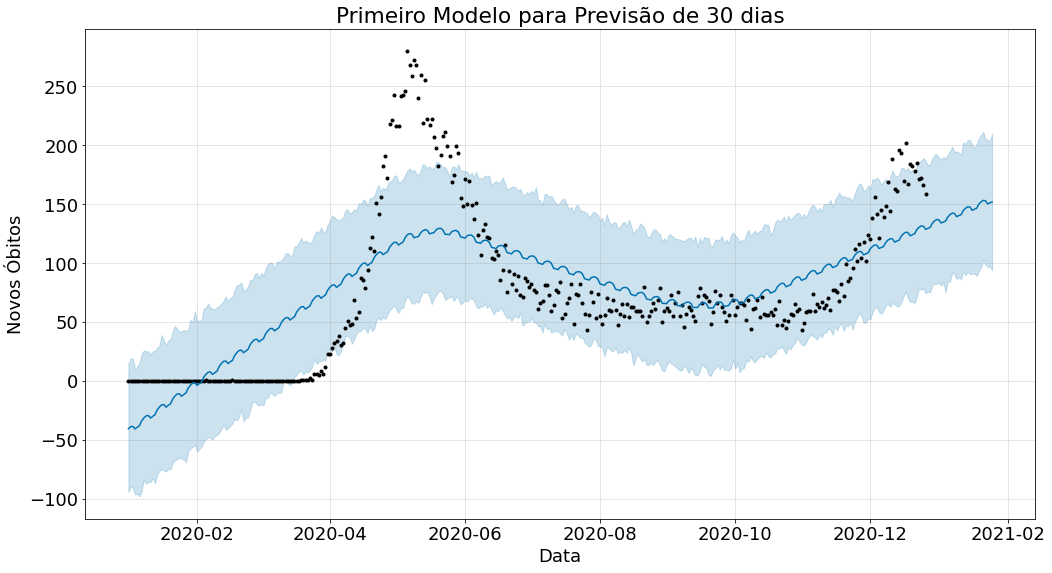

In [504]:
# Construindo visualização do modelo ingênuo
modelo.plot(previsao, xlabel='Data', ylabel='Novos Óbitos', figsize=(15, 8));
plt.title('Primeiro Modelo para Previsão de 30 dias')
plt.show()

---
Dividiremos a base de dados em duas, sendo a primeira com o objetivo de treinar
o modelo como fizemos anteriormente. A segunda massa de dados será utilizada
para testar o quão longe dos pontos reais, as previsões ficaram. Dessa forma, 
poderemos medir a qualidade do modelo gerado.

Temos dados contendo a evolução de novos óbitos do ano de 2020 do estado do Rio de Janeiro. A última semana do ano teve de ser retirada do dataframe porque 
apresentava uma variação anormal da série. Acredita-se que os dados referentes
à semana citada ficaram represados e serão inseridos na base do ano de seguinte.

Logo, há 361 resultados para utilização na criação do modelo. Desses 361, 
utilizaremos 331 resultados para treinar o modelo. Os outros 30 dias serão 
utilizados para testar quão boas são as previsões apresentadas. Observe que
30 dias é aproximadamente 1 mes de um ano. Então, serão utilizados
quase 11 meses para treino e 1 mes para os testes. A base de testes possui o
mesmo tamanho do período que desejamos prever ao final da criação do modelo.


---

In [505]:
# Criando o DataFrame de Treino
dados_para_treino = pd.DataFrame()
dados_para_treino['ds'] = dados_rj['Data'][:331]
dados_para_treino['y'] = dados_rj['Novos Óbitos'][:331]

# Criando o DataFrame de Teste
dados_para_teste = pd.DataFrame()
dados_para_teste['ds'] = dados_rj['Data'][331:]
dados_para_teste['y'] = dados_rj['Novos Óbitos'][331:]

# Treinando o modelo
modelo = Prophet()
modelo.fit(dados_para_treino)

# Realizando a previsão para 30 dias
periodo_de_previsao = modelo.make_future_dataframe(periods=periodo)
previsao = modelo.predict(periodo_de_previsao)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---
Como pode ser visto na visualização a seguir, o modelo ainda é muito ingênuo, seguindo apenas uma última tendência que identificou os dados. Em um período curto de tempo os dados de teste ainda estão dentro do intervalo de confiança das previsões. No entanto, para 30 dias, grande parte das previsões estão distantes demais dos dados de teste. Em vermelho se encontram os dados de teste.

---

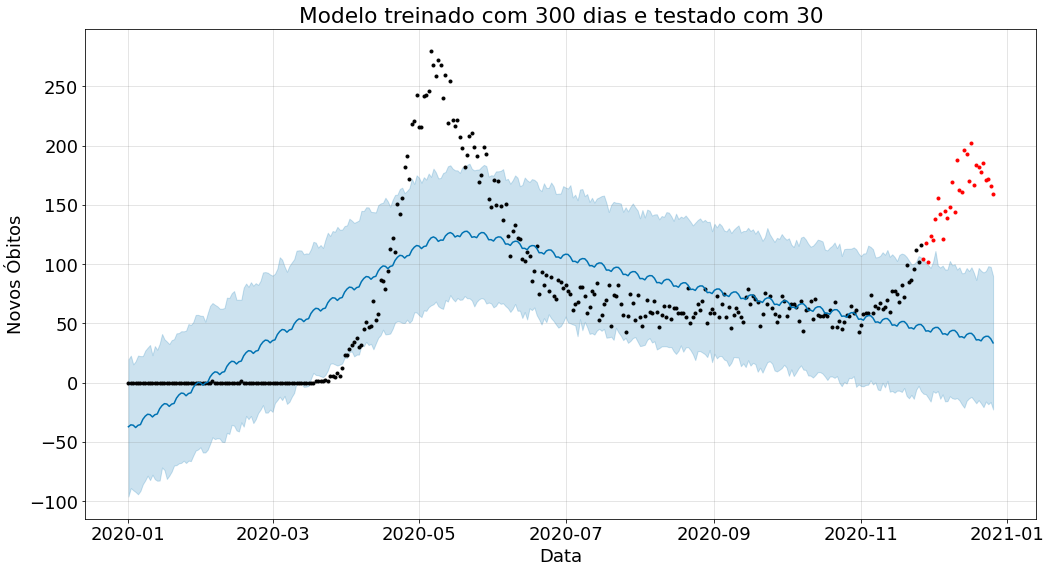

In [506]:
# Modelo ingênuo
modelo.plot(previsao, xlabel='Data', ylabel='Novos Óbitos', figsize=(15, 8));
plt.title('Modelo treinado com 300 dias e testado com 30')
plt.plot(dados_para_teste['ds'], dados_para_teste['y'], '.r')
plt.show()

---
A seguir são visualizados os componentes de tendência geral dos dados e identificação de sazonalidade desse primeiro gráfico. Como pode ser visto, a tendência geral não apresenta a segunda onda de óbitos que pode ser notada nos gráficos anteriores, o que indica que precisamos melhorar o modelo.

A componente de sazonalidade semanal apresenta que o modelo identificou
na base de dados que maiores valores ocorrem nos dias úteis da semana. Observe
que culturalmente, no estado do Rio de Janeiro, os dias de segunda-feira
apresentam resultados inferiores devido ao retorno do final de semana.

---

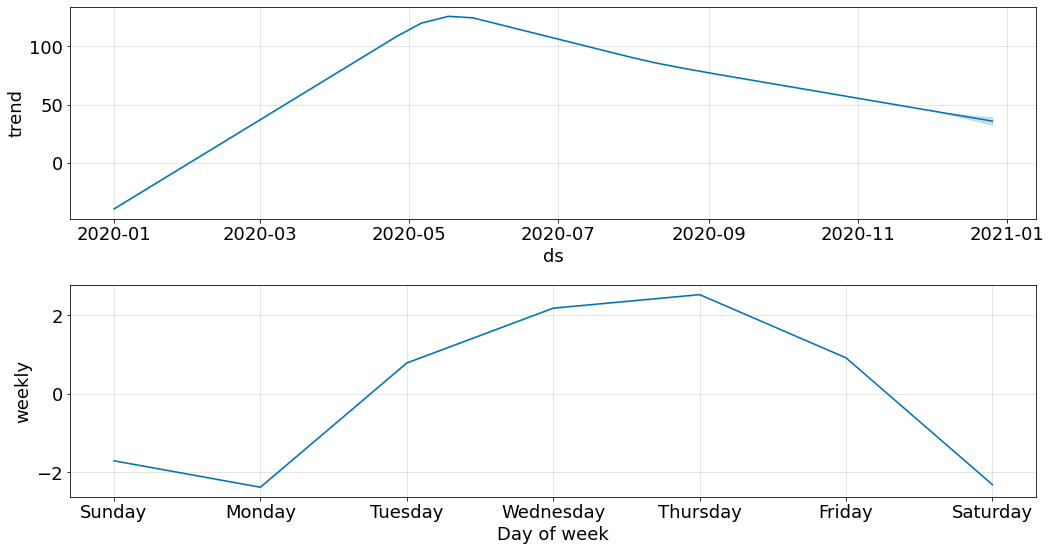

In [507]:
# Construindo componentes
modelo.plot_components(previsao, figsize=(15, 8));
plt.show()

# Melhorando o Modelo de Previsão de 30 dias de Novos Óbitos

---
Visualizando os pontos de mudança de tendência identificados pelo modelo 
ingênuo criado na seção anterior. Como podemos ver, o primeiro treino do 
modelo apenas identificou duas regiões de mudanças de tendência. É preciso
que o modelo identifique uma nova região antes da primeira, uma antes da 
segunda e uma depois da terceira. Com isso, as ondas de novos óbitos serão
modeladas mais adequadamente.

---

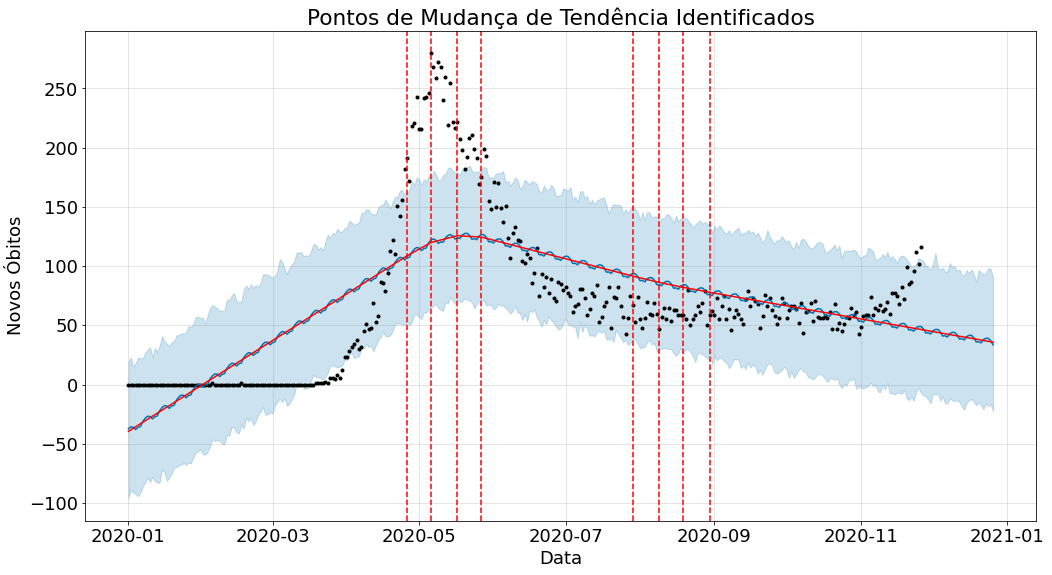

In [508]:
# Changepoints
fig = modelo.plot(previsao, figsize=(15, 8))
pontos_de_inflexao = add_changepoints_to_plot(fig.gca(), modelo, previsao)
plt.title('Pontos de Mudança de Tendência Identificados')
plt.xlabel('Data')
plt.ylabel('Novos Óbitos')
plt.show()

---
Para melhorar o modelo ingênuo, iremos aumentar o número de pontos de inflexão
e modificar a prioridade de escala desses pontos. O intuito é de melhor 
adequar o modelo aos dados de treino para realizar previsões mais acertadas.

Serão utilizados diferentes valores para os parâmetros indicados para melhorar
o modelo ingênuo e, ao mesmo tempo, evitar um treinamento demasiado do modelo
(overfit). Um caso de overfit implica em o modelo estar muito bem preparado para os dados de treino que não consegue prever adequadamente o novo.

---

In [509]:
# Função para criar os modelos
def create_model(changepoints, prior_scale, dados_treino, periodo_de_previsao):
  modelo = Prophet(n_changepoints=changepoints, changepoint_prior_scale=prior_scale)
  modelo.fit(dados_treino)
  futuro = modelo.make_future_dataframe(periods=periodo_de_previsao)
  previsao = modelo.predict(futuro)

  fig = modelo.plot(previsao, figsize=(15, 8))
  pontos_de_inflexao = add_changepoints_to_plot(fig.gca(), modelo, previsao)
  plt.title(f'Modelo para {changepoints} Pontos de Inflexão e {prior_scale} de Prior Scale')
  plt.xlabel('Data')
  plt.ylabel('Novos Óbitos')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


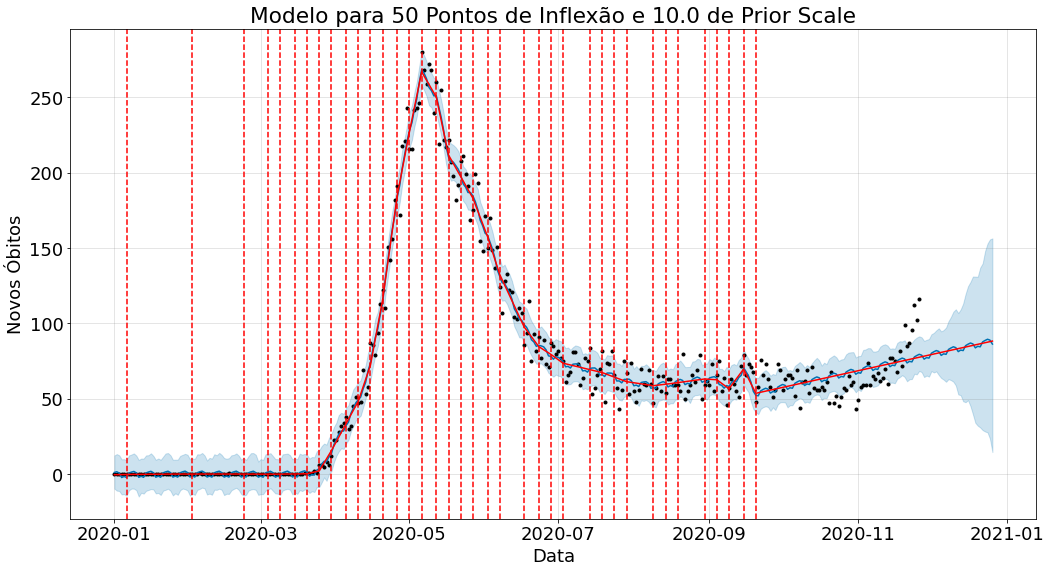

In [510]:
# Primeiro modelo 50 e 10.0
# Pode-se notar um overfit no resultado. É um modelo exagerado.
create_model(50, 10.0, dados_para_treino, periodo)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


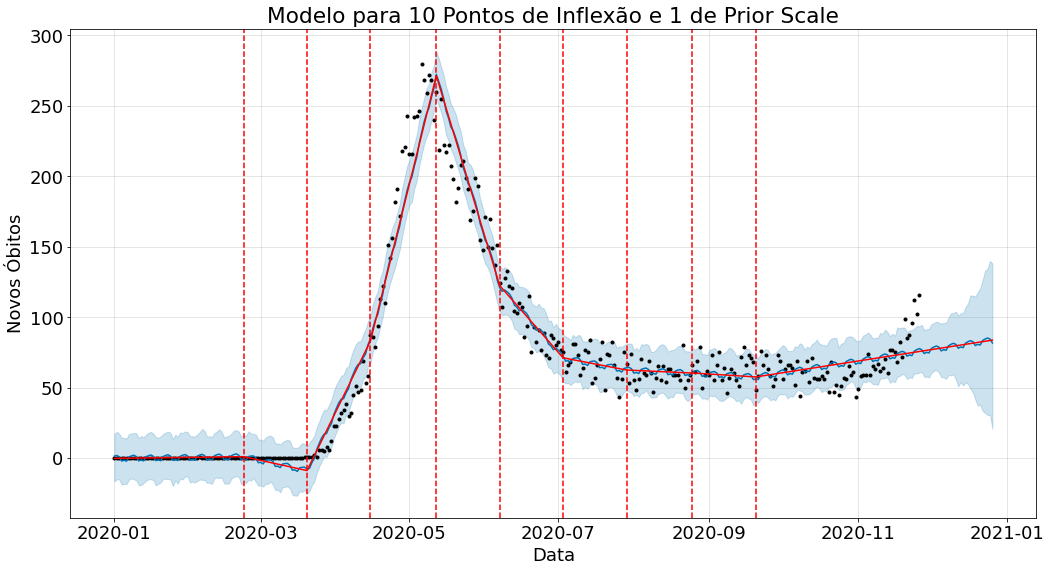

In [511]:
# Segundo modelo
# Apresenta uma boa adequação aos pontos. No entanto, ainda pode ser melhorado.
create_model(10, 1, dados_para_treino, periodo)

---
Durante os testes, se mostrou mais promissor o uso de um modelo intermediário a seguir entre o overfit e o outro com baixos parâmetros. Pode ser percebida a necessidade de se adicionar um ponto de inflexão na base da segunda onda de óbitos, uma vez que nenhum dos modelos testados está apresentando essa percepção que pode-se ser identificada visualmente nos gráficos.

---

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


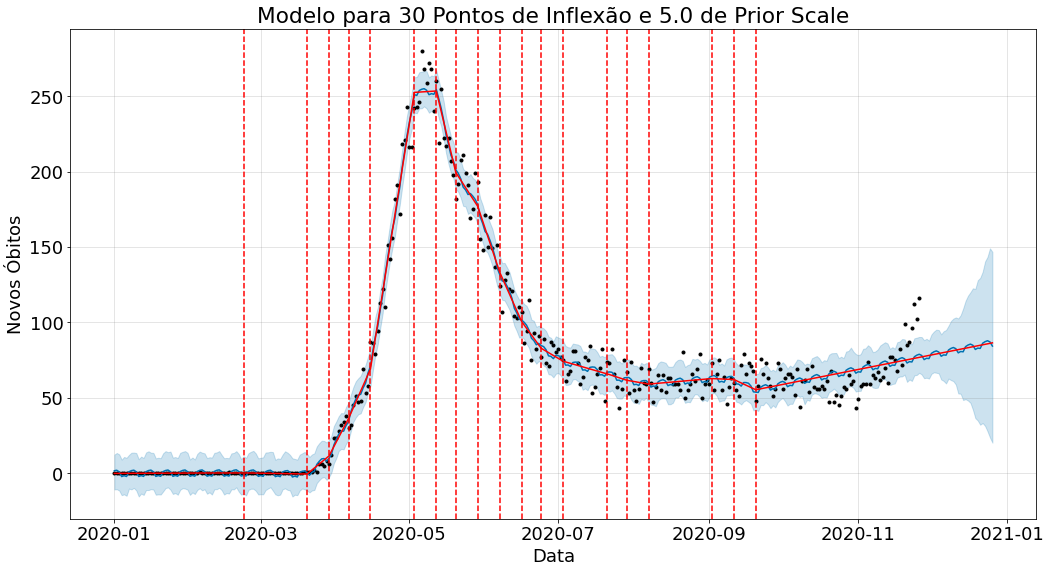

In [512]:
# Modelo intermediário
create_model(30, 5.0, dados_para_treino, periodo)

---
A falta de identificação da segunda onda é causada devido a posição dela ser
maior do que 80% do meu conjunto de dados. Por padrão, a biblioteca utilizada
não aceita essa adição de pontos. Teremos que acrescentar os changepoints 
acima dos 80% na mão para identificar a segunda onda de novos óbitos. A seguir teremos um modelo bastante adequado à base de dados.

---

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


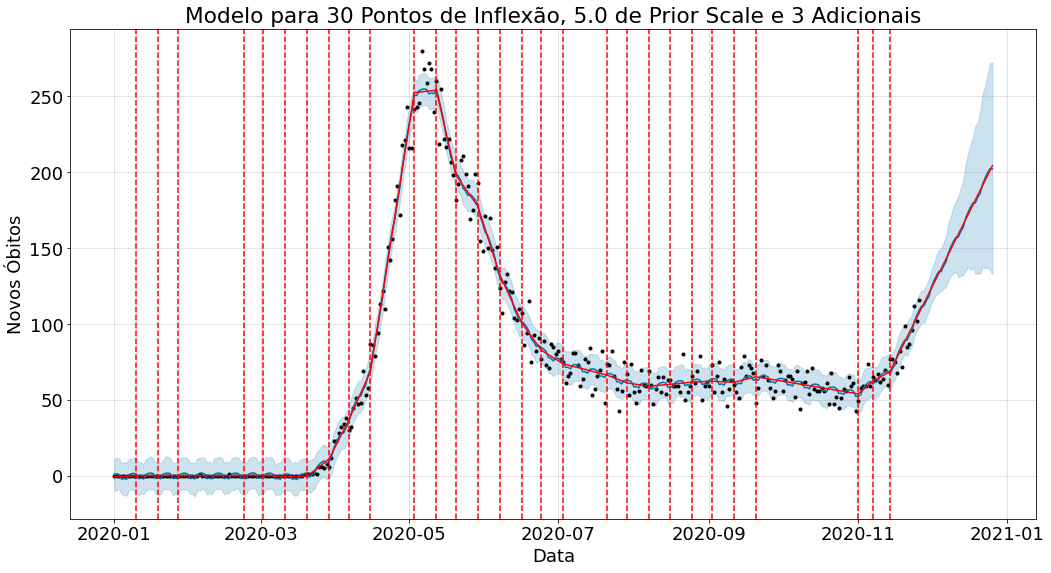

In [513]:
# Criando modelo com pontos de inflexão na base da segunda onda
modelo = Prophet(n_changepoints=30, changepoint_prior_scale=5.0)
modelo.fit(dados_para_treino)

changepoints = modelo.changepoints
new_changepoints = []
for changepoint in changepoints:
  new_changepoints.append(str(changepoint).split(' ')[0])
new_changepoints.append('2020-11-01')
new_changepoints.append('2020-11-07')
new_changepoints.append('2020-11-14')

modelo = Prophet(changepoints=new_changepoints, changepoint_prior_scale=5.0)
modelo.fit(dados_para_treino)

periodo_de_previsao = modelo.make_future_dataframe(periods=periodo)
previsao = modelo.predict(periodo_de_previsao)

fig = modelo.plot(previsao, figsize=(15, 8))
pontos_de_inflexao = add_changepoints_to_plot(fig.gca(), modelo, previsao)
plt.title(f'Modelo para 30 Pontos de Inflexão, 5.0 de Prior Scale e 3 Adicionais')
plt.xlabel('Data')
plt.ylabel('Novos Óbitos')
plt.show()

# Adicionando Feriados

---
A biblioteca Facebook Prophet disponibiliza a funcionalidade de se adicionar os feriados da série temporal para que sejam feitos modelos mais adequados.
A base de dados em questão representa os números de novos óbitos diários para o estado do Rio de Janeiro.
Logo, serão utilizados os feriados estaduais daquele estado, extraídos de http://www.kaldix.com/brasil/calendario/rio-de-janeiro/feriados/ano-2020/

---

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


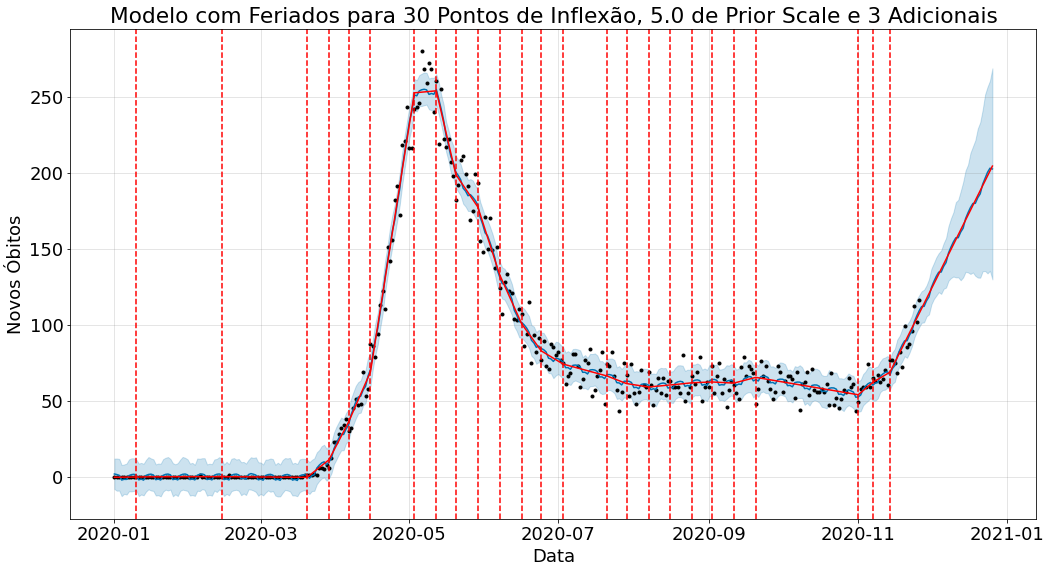

In [514]:
# Lista com feriados estaduais e federais do Rio de Janeiro para 2020
# http://www.kaldix.com/brasil/calendario/rio-de-janeiro/feriados/ano-2020/
feriados_rj_2020 = ['2020-01-01',
                    '2020-01-06',
                    '2020-02-22',
                    '2020-02-23',
                    '2020-02-24',
                    '2020-02-25',
                    '2020-02-26',
                    '2020-04-09',
                    '2020-04-10',
                    '2020-04-11',
                    '2020-04-12',
                    '2020-04-20',
                    '2020-04-21',
                    '2020-05-01',
                    '2020-06-11',
                    '2020-06-12',
                    '2020-09-07',
                    '2020-10-19',
                    '2020-10-28',
                    '2020-11-02',
                    '2020-11-15',
                    '2020-12-24',
                    '2020-12-25',
                    '2020-12-31']

# Criando o Dataframe de feriados
feriados_rj_2020 = pd.DataFrame({'holiday': 'rj_2020', 'ds': pd.to_datetime(feriados_rj_2020)})

modelo = Prophet(n_changepoints=30, changepoint_prior_scale=5.0, holidays=feriados_rj_2020)
#modelo.add_country_holidays(country_name='BR')
modelo.fit(dados_para_treino)

# Adicionando pontos de inflexão extras
changepoints = modelo.changepoints
new_changepoints = []
for changepoint in changepoints:
  new_changepoints.append(str(changepoint).split(' ')[0])
new_changepoints.append('2020-11-01')
new_changepoints.append('2020-11-07')
new_changepoints.append('2020-11-14')

# Recriando o modelo
modelo = Prophet(changepoints=new_changepoints, changepoint_prior_scale=5.0, holidays=feriados_rj_2020)
modelo.fit(dados_para_treino)

# Realizando previsão
periodo_de_previsao = modelo.make_future_dataframe(periods=periodo)
previsao = modelo.predict(periodo_de_previsao)

# Criando visualização
fig = modelo.plot(previsao, figsize=(15, 8))
pontos_de_inflexao = add_changepoints_to_plot(fig.gca(), modelo, previsao)
plt.title(f'Modelo com Feriados para 30 Pontos de Inflexão, 5.0 de Prior Scale e 3 Adicionais')
plt.xlabel('Data')
plt.ylabel('Novos Óbitos')
plt.show()

---
Com a adição dos feriados ao modelo, pode-se visualizar o efeito dos mesmos
no conjunto de dados. A seguir se encontram as visualizações dos componentes do modelo em construção. Observe que logo após os feriados há picos de mortes.
Julga-se que esta característica se deve ao represamento dos dados de óbitos
nos feriados, sendo estes reportados somente no dia útil seguinte.

---

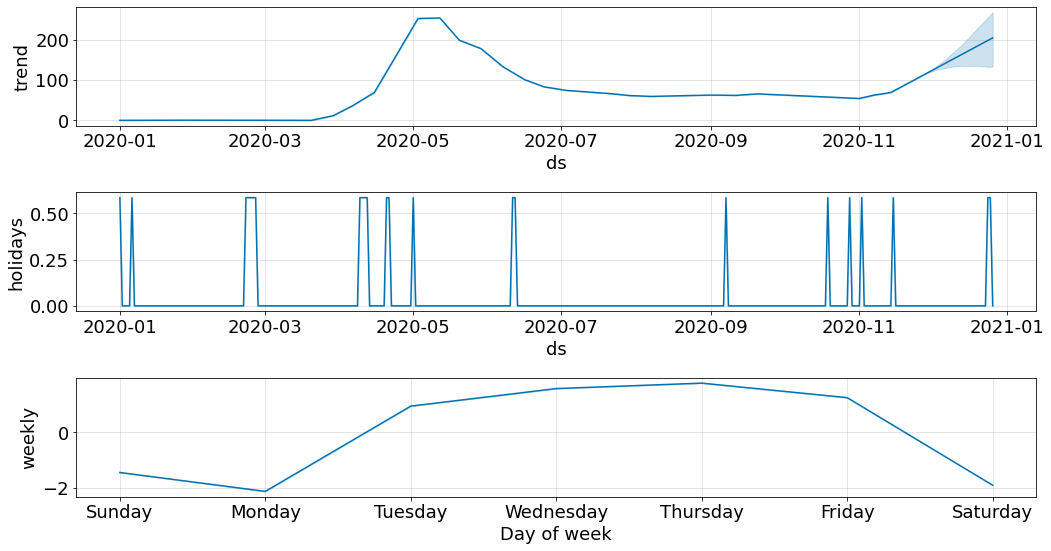

In [515]:
# Exibição dos componentes do modelo
modelo.plot_components(previsao, figsize=(15, 8));

# Avaliando Sazonalidaes do Modelo com Métricas

---
## Facebook Prophet e Sazonalidades
A biblioteca do Facebook Prophet apresenta dois tipos de sazonalidade que podemos utilizar na construção do modelo.
A fornecida como padrão no construtor é a sazonalidade aditiva. 
Caso queira modificar, há a possibilidade de seleção da multiplicativa.

### Sazonalidade Aditiva
Na sazonalidade aditiva a flutuação sazonal de um trecho da série temporal é somada aos valores daquele trecho, não importando outras flutuações que ocorram no restante da série. 
Um exemplo para este caso seria venda de roupas de inverno. 
No verão será mais baixa e no inverno será mais alta, impactando naquele ponto.

É dada pela fórmula:
```
y(t) = Nível + Tendência + Sazonalidade + Ruído
```

### Sazonalidade Multiplicativa
O nível que a série temporal assume durante toda a sua evolução impacta diretamente na amplitude de uma alta ou baixa local.
Por exemplo, no caso da venda de roupas de inverno, se o aumento das vendas for impactado por como estão ocorrendo as vendas no ano inteiro, então a sazonalidade multiplicativa será mais adequada.
Nesse caso específico, sabemos que vendas são impactadas diretamente pelo estado da economia local.
Logo, a amplitude do aumento de vendas de roupas de frio no inverno, pode depender diretamente do estado da economia no período anterior, o que se reportará em como estão as vendas em um passado recente.

É dada pela fórmula:
```
y(t) = Nível * Tendência * Sazonalidade * Ruído
```

#####(Fonte: https://www.alura.com.br/artigos/series-temporais-tipos-de-sazonalidade)


## Métrica para avaliação
Será utilizado o erro  médio absoluto (<i>Mean Absolut Error - MAE</i>) com métrica para avaliação dos modelos construídos. 
O erro escolido representa o somatório das distâncias de cada ponto da base de dados ao ponto que o modelo representou, dividido pelo total de pontos somado.
Para este cálculo não é levado em consideração o sinal do erro, ou seja, apenas as distâncias em módulo importam.

---

In [516]:
# Será utilizado o erro médio absoluto para a avaliação das sazonalidades
# multiplicativa e aditiva nos modelos

# MAE da Aditiva nos dados de treino
mean_absolute_error(dados_para_treino['y'], previsao['yhat'][:331])

6.039704595984118

In [517]:
# MAE da Aditiva nos dados de teste
mean_absolute_error(dados_para_teste['y'], previsao['yhat'][331:])

13.971798816580163

In [518]:
modelo_multi = Prophet(n_changepoints=30, changepoint_prior_scale=5.0, holidays=feriados_rj_2020, seasonality_mode='multiplicative')
modelo_multi.fit(dados_para_treino)

# Adicionando pontos de inflexão extras
changepoints = modelo.changepoints
new_changepoints = []
for changepoint in changepoints:
  new_changepoints.append(str(changepoint).split(' ')[0])
new_changepoints.append('2020-11-01')
new_changepoints.append('2020-11-07')
new_changepoints.append('2020-11-14')

# Recriando o modelo
modelo_multi = Prophet(changepoints=new_changepoints, changepoint_prior_scale=5.0, holidays=feriados_rj_2020, seasonality_mode='multiplicative')
modelo_multi.fit(dados_para_treino)

# Realizando previsão
periodo_de_previsao = modelo_multi.make_future_dataframe(periods=periodo)
previsao_multi = modelo_multi.predict(periodo_de_previsao)

# MAE da Multiplicativa
mean_absolute_error(dados_para_treino['y'], previsao_multi['yhat'][:331])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5.689544253765447

In [519]:
# MAE da Multiplicativa nos dados de teste
mean_absolute_error(dados_para_teste['y'], previsao_multi['yhat'][331:])

13.64089902965579

---
Até o presente momento, pode ser visto na comparação do erro médio absoluto, que a sazonalidade multiplicativa ofereceu um valor melhor. 
Logo, essa será utilizada para a configuração dos próximos passos do modelo. 
A seguir é apresentada a visualização do modelo com a base de testes em pontos verdes. 
Observe que a base de testes está quase completamente dentro do intervalo de confiança do modelo. 

Ou seja, o modelo está indicando que pode vir uma segunda onda de novos óbitos 
maior do que a primeira ou esta pode ser um pouco menor e a curva decrescer.
Como a curva vai se comportar depende diretamente das medidas sanitárias que
o estado do Rio de Janeiro tomaria nos dias que seguem o período analisado.

---

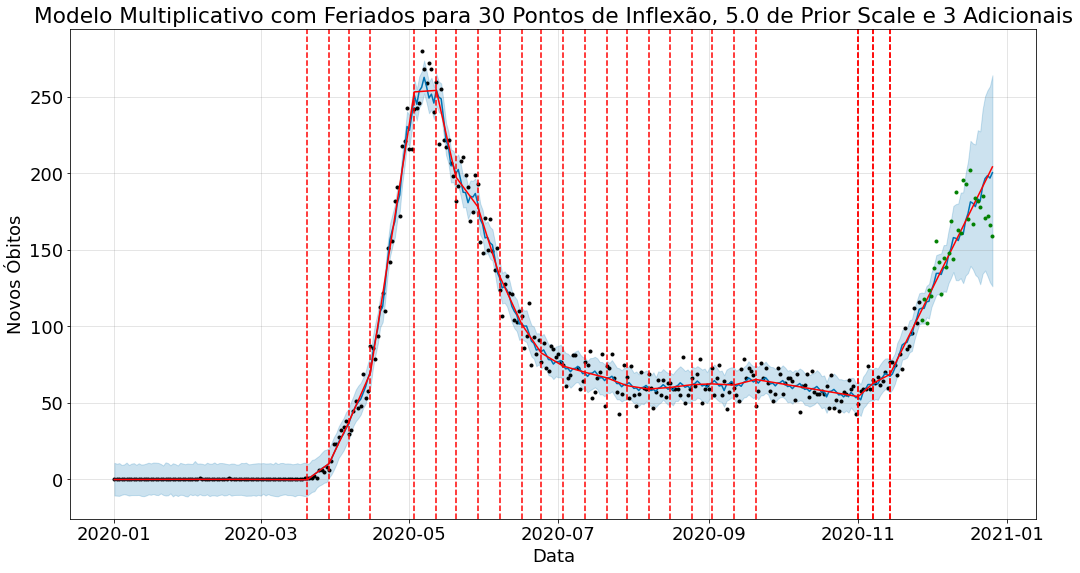

In [520]:
# Criando visualização
fig = modelo_multi.plot(previsao_multi, figsize=(15, 8))
pontos_de_inflexao = add_changepoints_to_plot(fig.gca(), modelo_multi, previsao_multi)
plt.plot(dados_para_teste['ds'], dados_para_teste['y'], '.g')
plt.title(f'Modelo Multiplicativo com Feriados para 30 Pontos de Inflexão, 5.0 de Prior Scale e 3 Adicionais')
plt.xlabel('Data')
plt.ylabel('Novos Óbitos')
plt.show()

# Removendo Outiliers da Base para Melhorar o Modelo

---
Outlier é o nome dado a pontos discrepantes em um conjunto de dados. 
Esses pontos podem ocorrer por erros em medições ou simplesmente por condições
especiais como feriados ou represamento de dados. 
É importante indicar que outliers podem prejudicar a criação do modelo, uma vez que este pode adquirir alguns desvios devido a discrepância dos valores.

Como critério para remoção de outliers, será usado pontos fora do intervalo de 
confiança da curva de novos óbitos do modelo. Esses pontos serão identificados e removidos da base de dados para realizar um novo treinamento do modelo.

Na visualização, em verde estão os dados da base que se encontram dentro do
intervalo de confiança do modelo. Em vermelho, estão os pontos que são considerados outliers segundo o critério aqui especificado.

---

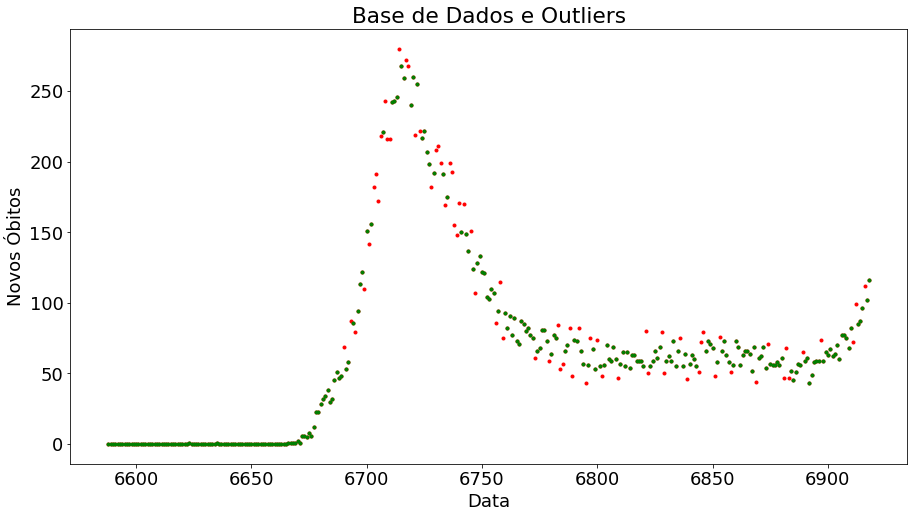

In [521]:
# Identificação de outliers
dados_para_treino_reset = dados_para_treino.reset_index()
dados_para_treino_sem_outlier = dados_para_treino_reset[(dados_para_treino_reset['y'] >= previsao_multi['yhat_lower'][:331]) & (dados_para_treino_reset['y'] <= previsao_multi['yhat_upper'][:331])]
plt.plot(dados_para_treino_reset['index'], dados_para_treino_reset['y'], '.r')
plt.plot(dados_para_treino_sem_outlier['index'], dados_para_treino_sem_outlier['y'], '.g')
plt.title(f'Base de Dados e Outliers')
plt.xlabel('Data')
plt.ylabel('Novos Óbitos')
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


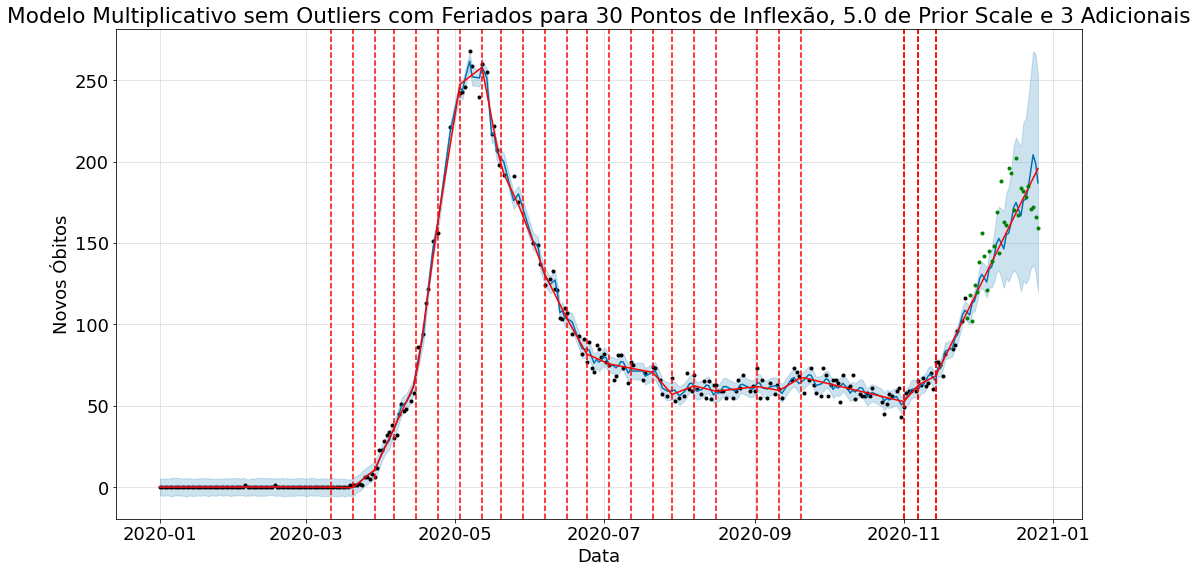

In [522]:
# Criando base de dados sem outliers
dados_para_treino_sem_outlier = dados_para_treino_sem_outlier[['ds', 'y']]

# Criando modelo
modelo_multi_sem_outlier = Prophet(n_changepoints=30, changepoint_prior_scale=5.0, holidays=feriados_rj_2020, seasonality_mode='multiplicative')
modelo_multi_sem_outlier.fit(dados_para_treino_sem_outlier)

# Adicionando pontos de inflexão extras
changepoints = modelo.changepoints
new_changepoints = []
for changepoint in changepoints:
  new_changepoints.append(str(changepoint).split(' ')[0])
new_changepoints.append('2020-11-01')
new_changepoints.append('2020-11-07')
new_changepoints.append('2020-11-14')

# Recriando o modelo
modelo_multi_sem_outlier = Prophet(changepoints=new_changepoints, changepoint_prior_scale=5.0, holidays=feriados_rj_2020, seasonality_mode='multiplicative')
modelo_multi_sem_outlier.fit(dados_para_treino_sem_outlier)

# Realizando previsão
periodo_de_previsao = modelo_multi_sem_outlier.make_future_dataframe(periods=periodo)
previsao_multi_sem_outlier = modelo_multi_sem_outlier.predict(periodo_de_previsao)

# Criando visualização
fig = modelo_multi_sem_outlier.plot(previsao_multi_sem_outlier, figsize=(15, 8))
pontos_de_inflexao = add_changepoints_to_plot(fig.gca(), modelo_multi_sem_outlier, previsao_multi_sem_outlier)
plt.plot(dados_para_teste['ds'], dados_para_teste['y'], '.g')
plt.title('Modelo Multiplicativo sem Outliers com Feriados para 30 Pontos de Inflexão, 5.0 de Prior Scale e 3 Adicionais')
plt.xlabel('Data')
plt.ylabel('Novos Óbitos')
plt.show()

In [524]:
# MAE da Multiplicativa sem Outliers para treino
mean_absolute_error(dados_para_treino_sem_outlier['y'], previsao_multi_sem_outlier['yhat'][:263])

2.9310910672303483

In [525]:
# MAE da Multiplicativa sem Outliers para teste
mean_absolute_error(dados_para_teste['y'], previsao_multi_sem_outlier['yhat'][263:])

14.852986959592416

---
Levando em consideração os Erros Médios Absolutos (<i>Mean Absolut Error - MAE</i>) listados a seguir, o modelo que melhor realizou previsões comparados com a base de testes foi o Multiplicativo com a presença dos outliers. A retirada dos outliers do treinamento pode ter causado um overfit do modelo, o que impediu previsões melhores.

* Modelo Somativo
  * MAE para base de treino: 6.039704595984118
  * MAE para base de testes: 13.971798816580163
* Modelo Multiplicativo
  * MAE para base de treino: 5.689544253765447
  * MAE para base de testes: 13.64089902965579
* Modelo Multiplicativo sem Outliers:
  * MAE para base de treino: 2.9310910672303483
  * MAE para base de testes: 14.852986959592416

Para o fim de validação, será utilizado o modelo Multiplicativo com a presença dos outliers durante o treinamento.

---

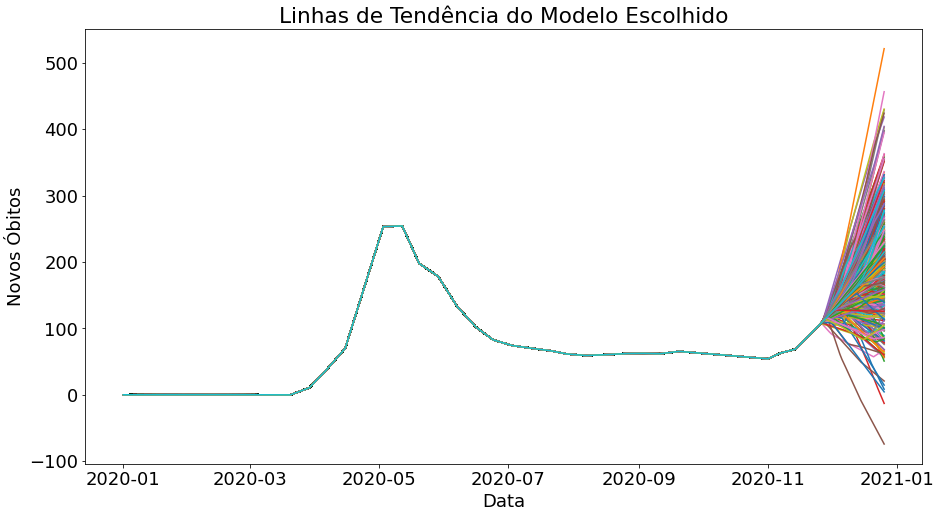

In [526]:
# Visualizando as possíveis tendências que a curva de novos óbitos pode assumir.
amostras = modelo_multi.predictive_samples(previsao_multi)
plt.plot(previsao_multi['ds'], amostras['trend']);
plt.title('Linhas de Tendência do Modelo Escolhido')
plt.xlabel('Data')
plt.ylabel('Novos Óbitos')
plt.show()

# Validação Cruzada do Modelo

---
O conjunto de dados disponível será dividido em recortes de modo a possibilitar uma validação cruzados do modelo criado.
Esse tipo de validação requer um conjunto de dados para o treinamento do modelo, em seguida um segundo para validação e por fim o de teste.
A validação cruzada realiza diversos recortes e uma validação do modelo em várias etapas. 
Com isso, se pode aferir o quanto o modelo é capaz de acertar nas previsões em cada trecho da curva de novos óbitos.
Ao final, os erros das predições da validação cruzada serão avaliados para se ter uma ideia completa de quão bom o modelo é.

---

In [527]:
# Criando dataframe de validação cruzada do modelo
validacao_cruzada = cross_validation(modelo_multi, initial='90 days', period='30 days', horizon='30 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-31 00:00:00 and 2020-10-27 00:00:00


In [528]:
ordinal = [
           'Primeira',
           'Segunda',
           'Terceira',
           'Quarta',
           'Quinta',
           'Sexta',
           'Sétima',
           'Oitava',
           'Nona',
           'Décima'
]

def plot_cross_validation(janela):
  recortes = validacao_cruzada['cutoff'].unique()
  recorte_selecionado = recortes[janela]
  dados_do_recorte_selecionado = validacao_cruzada[validacao_cruzada['cutoff'].values == recorte_selecionado]

  fig = plt.figure(figsize=(15, 8))
  ax = fig.add_subplot(111)
  ax.plot(modelo_multi.history['ds'].values, modelo_multi.history['y'], 'k.')
  ax.plot(dados_do_recorte_selecionado['ds'].values, dados_do_recorte_selecionado['yhat'], ls='-', c='#0072B2')
  ax.fill_between(dados_do_recorte_selecionado['ds'].values, dados_do_recorte_selecionado['yhat_lower'],
                  dados_do_recorte_selecionado['yhat_upper'], color='blue',
                                  alpha=0.20)
  ax.axvline(x=pd.to_datetime(recorte_selecionado), c='gray', lw=4, alpha=0.5)
  plt.ylabel('Número de Óbitos')
  plt.xlabel('Data')
  plt.xticks(rotation=30)
  plt.title(f'{ordinal[janela]} Janela de Validação')
  plt.show()

---
A seguir serão apresentados cada um dos recortes realizados pela validação cruzada. 
Também serão exibidas as previsões em cada etapa.

---

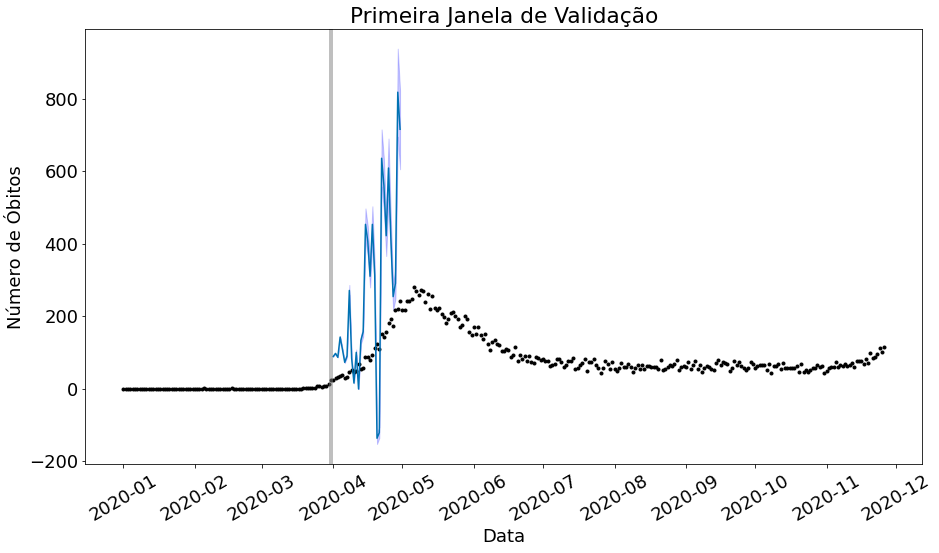

In [529]:
# Primeiro recorte
plot_cross_validation(0)

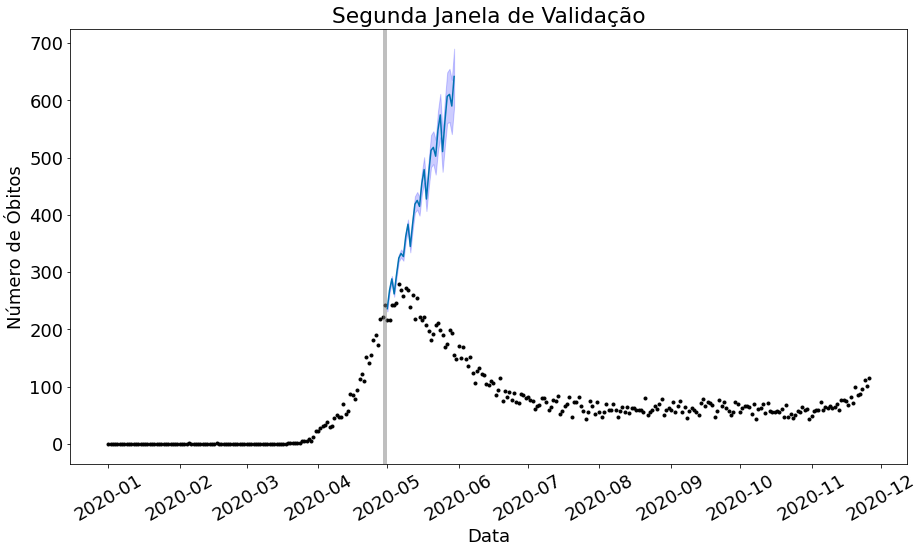

In [530]:
# Segundo recorte
plot_cross_validation(1)

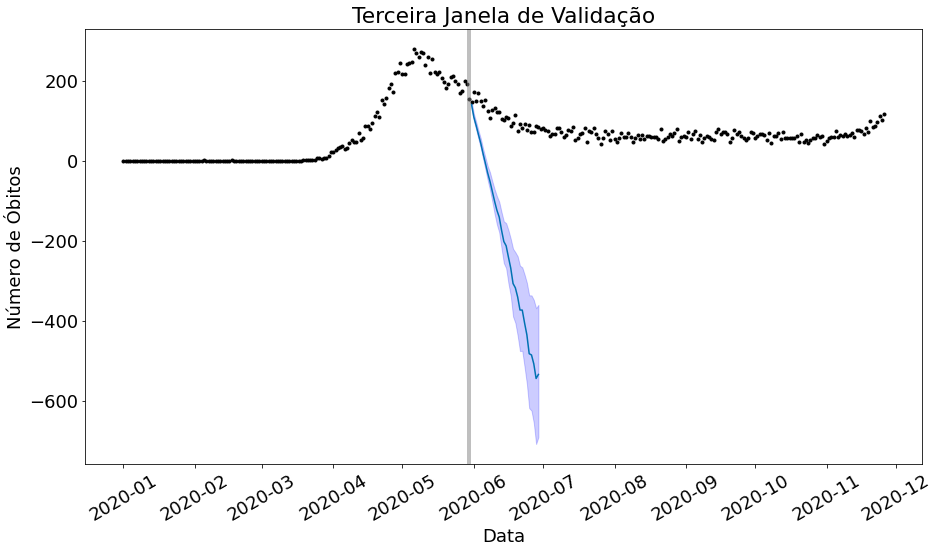

In [531]:
# Terceiro recorte
plot_cross_validation(2)

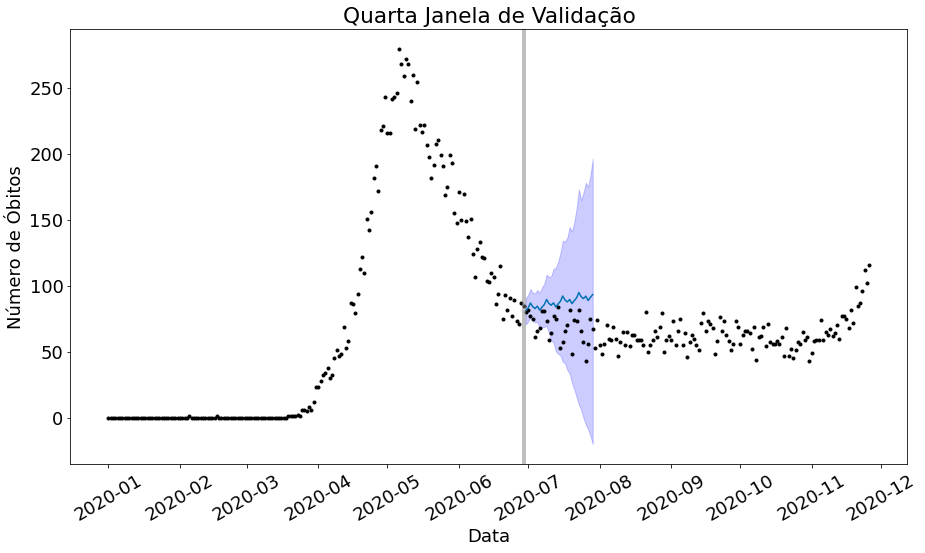

In [532]:
# Quarto recorte
plot_cross_validation(3)

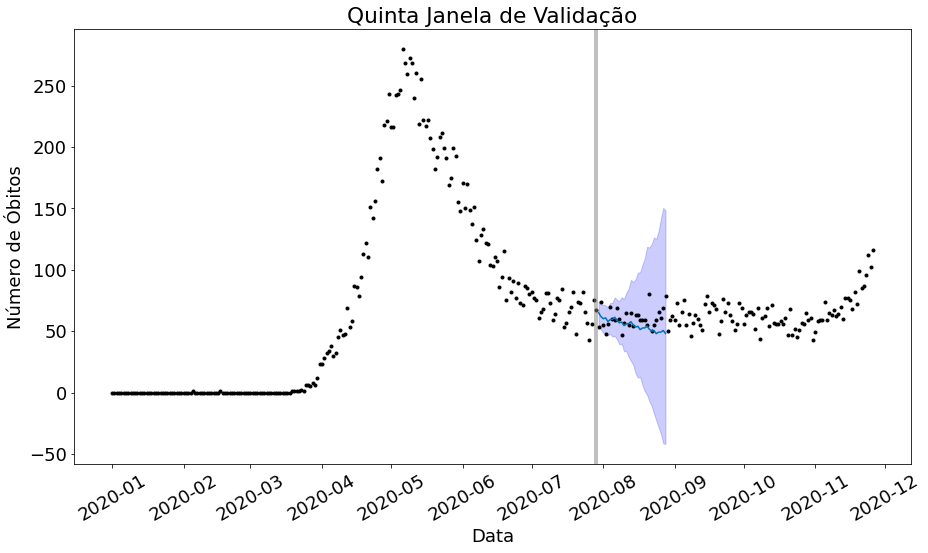

In [533]:
# Quinto recorte
plot_cross_validation(4)

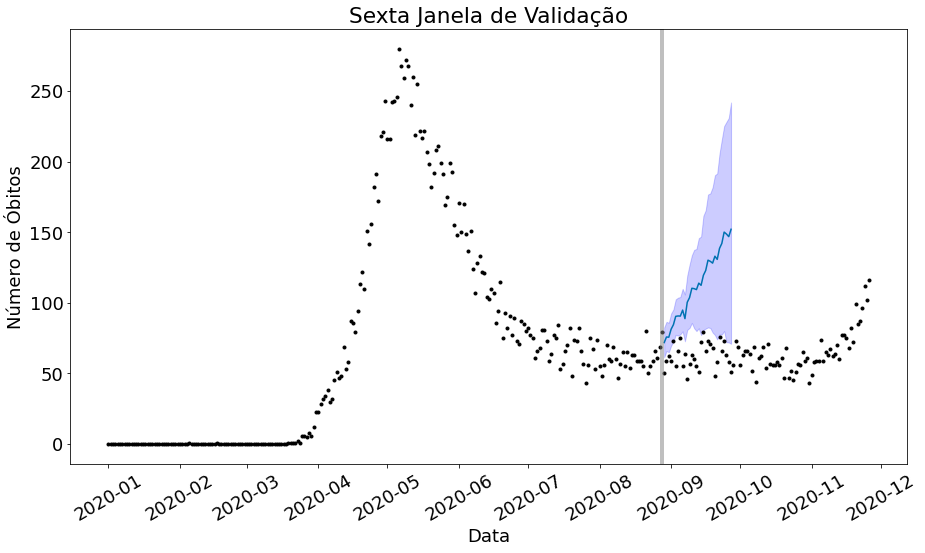

In [534]:
# Sexto recorte
plot_cross_validation(5)

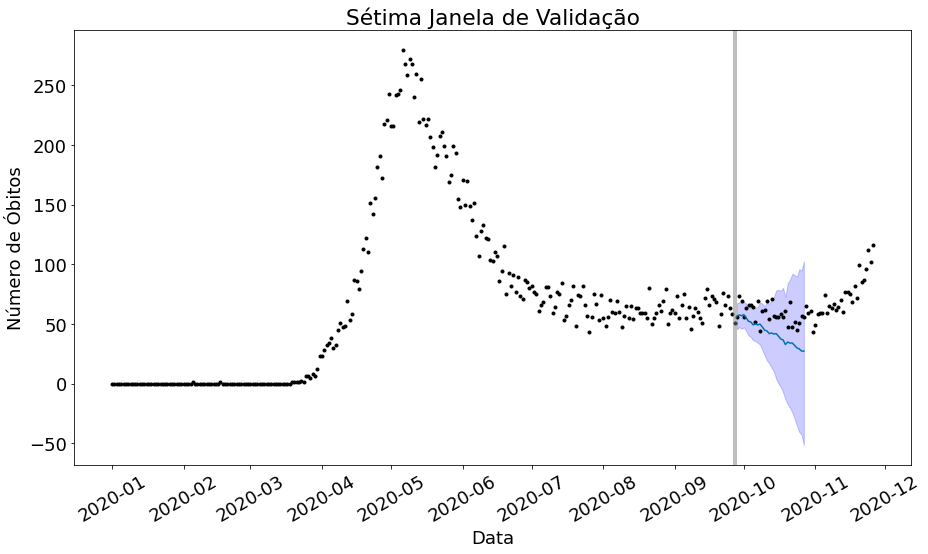

In [535]:
# Sétimo recorte
plot_cross_validation(6)

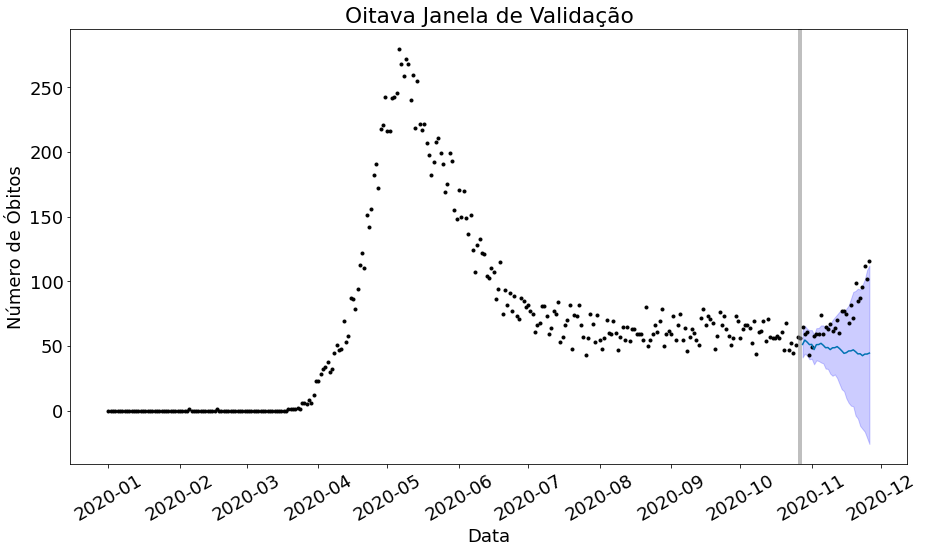

In [536]:
# Oitavo recorte
plot_cross_validation(7)

---
A seguir temos os diferentes tipos de erros para as previsões a partir de 3 dias
até 30 dias no futuro. Isso demonstra o quanto o modelo está adequado para
fazer previsões de diferentes intervalos de tempo. Até 5 dias no futuro, o erro não passa de 100 novos óbitos diários para mais ou para menos. 
Para prever 30 dias no futuro, o modelo pode errer em até 700 casos.
Mesmo nesse caso, o erro médio absoluto em sua média não passa de 200
novos casos. Para a aceitação do modelo, deve-se levar em consideração o tamanho
do erro que eu posso assumir no meu negócio. 

---

In [537]:
# Cálculo dos erros para os intervalos de tempo
metricas_de_performance = performance_metrics(validacao_cruzada)
metricas_de_performance

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1127.025269,33.571197,24.464728,0.448406,0.201173,0.333333
1,4 days,1885.447769,43.421743,30.426056,0.488736,0.201173,0.333333
2,5 days,2179.493382,46.685045,31.953209,0.474594,0.189569,0.416667
3,6 days,2618.023484,51.166625,35.444789,0.510644,0.203959,0.375000
4,7 days,3010.738997,54.870201,37.723740,0.475739,0.213528,0.333333
5,8 days,5549.345531,74.493929,46.963064,0.629508,0.224680,0.291667
6,9 days,6236.772473,78.973239,49.667129,0.621493,0.236055,0.333333
7,10 days,7247.388768,85.131597,53.174087,0.612326,0.275155,0.375000
8,11 days,6939.785269,83.305374,53.748536,0.544169,0.358668,0.333333
9,12 days,8906.254366,94.372954,61.165606,0.603576,0.409465,0.375000


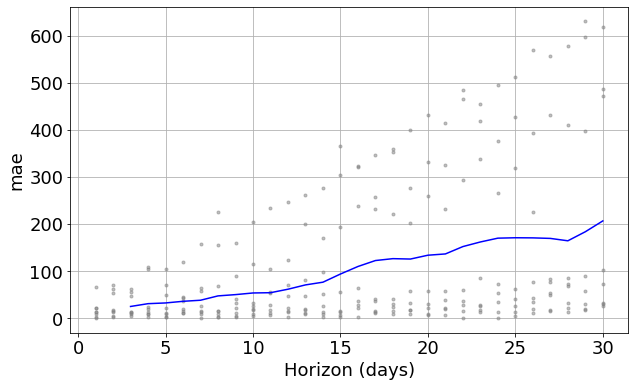

In [538]:
# Construção da visualização do MAE
plot_cross_validation_metric(validacao_cruzada, metric='mae');

# Conclusão

---
Mediante todos os dados analisados e o modelo construído, pode-se concluir que há uma forma de se criar um modelo preditivo para o número de novos óbitos por dia por COVID19 no estado do Rio de Janeiro.
O modelo em questão precisa levar em consideração os feriados do estado e deve utilizar um modelo de sazonalidade multiplicativo.
O erro médio absoluto para o modelo obtido varia de 24 casos com 3 dias a 206 casos com 30 dias.
O modelo em questão pode ser utilizado para o cálculo de risco de novas medidas sanitárias para o estado ou a reabertura gradual após um fechamento dos serviços.

---